# ML for currency prediction: USD/CHF 

## Preprocessing 

### Import & load data

In [581]:
%reload_ext autoreload
%autoreload 2

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm 
import random 

import torch
import torch.nn as nn

from sklearn.metrics import confusion_matrix


#%cd "/content/drive/My Drive/ml-project-2-marmlla_2/"
import Helper.Preprocessing as pp 
import Helper.Model as ml 
import Helper.Display as ds
import Helper.Pipeline as pl

df = pd.read_csv("Data/data_daily/dataset_daily.csv")
data = []
for i in df.columns[1:]:
    data.append(df[i])

df.head(2)

Date  Open_USD_CHF  Open_CHF_EUR  Open_CHF_GBP  Open_CHF_JPY  \
0  2001-12-27        1.6886        0.6723        0.4071         77.46   
1  2001-12-28        1.6776        0.6745        0.4106         78.48   

   Open_CHF_CAD  Open_BondCH1m  Open_BondCH2y  Open_BondCH10y  Open_SMI  \
0        0.9477           1.68          2.011           3.460    6392.1   
1        0.9520           1.68          2.059           3.474    6430.6   

   Open_USD_JPY  Open_USD_EUR  Open_USD_GBP  Open_USD_CAD  Open_BondUS1m  \
0        130.82        1.1356        0.6876        1.6010          1.751   
1        131.68        1.1319        0.6887        1.5981          1.720   

   Open_BondUS2y  Open_BondUS10y  Open_SP500  
0          3.307           5.072      1149.4  
1          3.169           5.113      1157.1

### Data distribution 

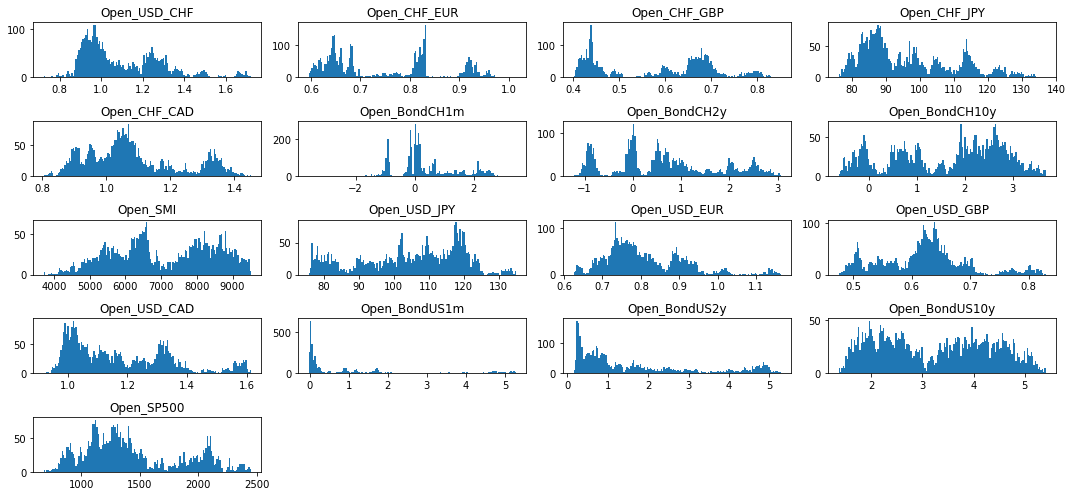

In [32]:
fig = plt.figure(figsize=(15, 7))

name  = df.columns[1:]

for i in range(len(data)):   
    plt.subplot(5, 4,1+i)
    plt.hist(data[i], bins=150)
    plt.title(name[i])
plt.tight_layout()
plt.show()

### Generate Dataset 

In [252]:
result_price_df = pd.DataFrame(index=['MSE','ACC','MEAN RET %'])
result_trend_df = pd.DataFrame(index=['ACC','MEAN RET %'])

device = 'cpu'
LOOKBACK = 6
span_trend = 4
fraction_val = 0.05
fraction_test = 0.2

# train_y, val_y, test_y WITH TREND LABEL: 0 or 1.
train_x, val_x, test_x, train_y, val_y, test_y, _, price_tuple= pp.generate_dataset(
  data,
  lookback_=LOOKBACK,
  trend_=True,
  span_trend_=span_trend,
  span_back_trend_= 0,
  norm_=True,
  fraction_val_=fraction_val,
  fraction_test_=fraction_test)

# rain_y_reg, val_y_reg, test_y_reg WITH PRICE LABEL: USD/CHF.
_, _, _, train_y_reg, val_y_reg, test_y_reg, norm, _= pp.generate_dataset(
  data,
  lookback_=LOOKBACK,
  trend_=False,
  span_trend_=span_trend,
  norm_=True,
  fraction_val_=fraction_val,
  fraction_test_=fraction_test)

Number nan: 85 (for var len = 2688)
Number nan: 8 (for var len = 142)
Number nan: 53 (for var len = 709)
Shape:             
X train     (2682, 6, 34), y train     (2682, 17)            
X train val (136, 6, 34) , y train val (136, 17)             
X test      (703, 6, 34) , y test      (703, 17)             
Price       3539
Number nan: 85 (for var len = 2688)
Number nan: 8 (for var len = 142)
Number nan: 53 (for var len = 709)
Shape:             
X train     (2682, 6, 34), y train     (2682, 17)            
X train val (136, 6, 34) , y train val (136, 17)             
X test      (703, 6, 34) , y test      (703, 17)             
Price       3539


In [253]:
train_x[np.isnan(train_x)] = 0.5 
val_x[np.isnan(val_x)] = 0.5
test_x[np.isnan(test_x)] = 0.5
train_y_reg[np.isnan(train_y_reg)] = 0.5 
val_y_reg[np.isnan(val_y_reg)] = 0.5
test_y_reg[np.isnan(test_y_reg)] = 0.5

train_y_reg[np.isnan(train_y_reg)] , val_y_reg[np.isnan(val_y_reg)], test_y_reg[np.isnan(test_y_reg)] 

(array([], dtype=float64), array([], dtype=float64), array([], dtype=float64))

In [574]:
buff = train_y[:,0]
positive_weight = torch.tensor(
        len(buff[buff == 0.0]) / len(buff[buff == 1.0])
    ).float().to(device)
print(positive_weight)

tensor(1.1542)


### Inspect feature 

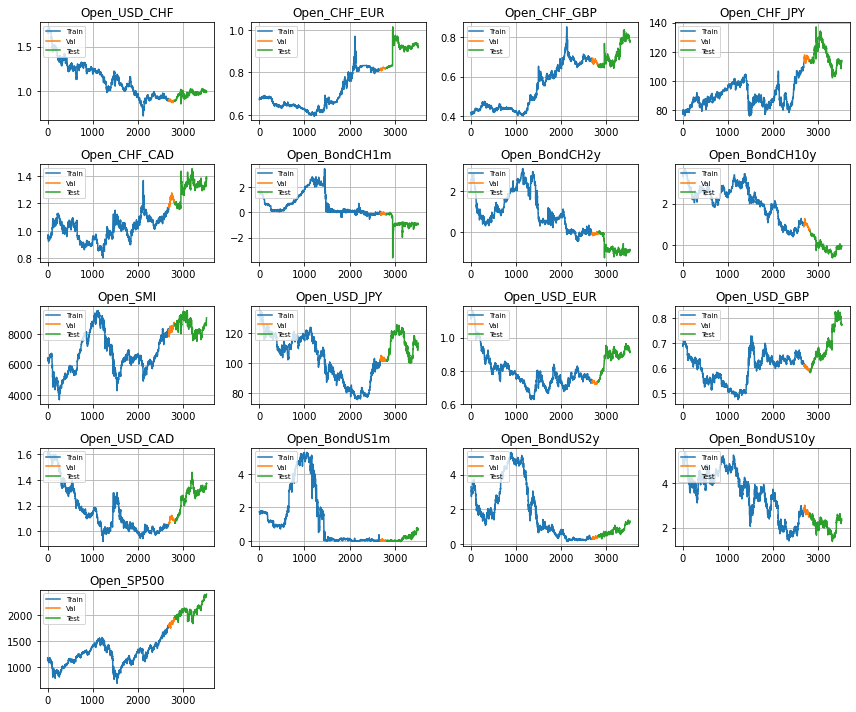

In [210]:
L1 = len(train_x)
L2 = len(val_x) + L1
L3 = len(test_x) + L2 

fig = plt.figure(figsize=(12, 10))
nb_data = len(data)
for i in range(nb_data):
  plt.subplot(5, 4,i+1)
  plt.title(name[i])
  plt.plot(np.arange(L1), data[i].iloc[:L1], label='Train')
  plt.plot(np.arange(L1, L2), data[i].iloc[L1:L2], label='Val')
  plt.plot(np.arange(L2,L3), data[i].iloc[L2:L3], label='Test')
  plt.grid()
  plt.legend(loc='upper left', fontsize=7)

plt.tight_layout()
plt.show()

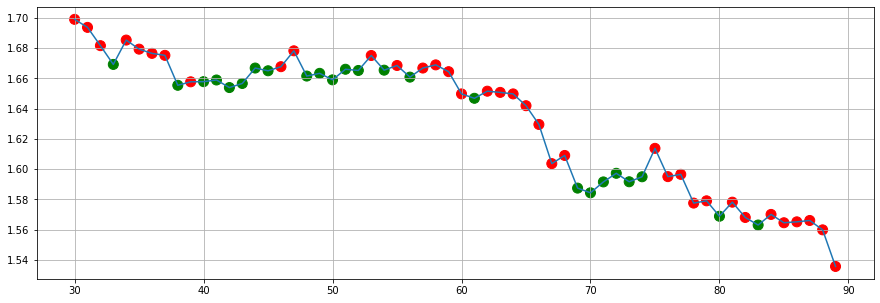

In [109]:
# TRAIN DATA
end = 90
start = 30

colors = {0:'red', 1:'green'}
plt.figure(figsize=(15,5))
scatter = plt.scatter(np.arange(start, end), price[start:end ], c=pd.Series(train_y[start:end,0]).map(colors).values, s=100)
plt.plot(np.arange(start, end), price[start: end ])

plt.grid()
plt.show()

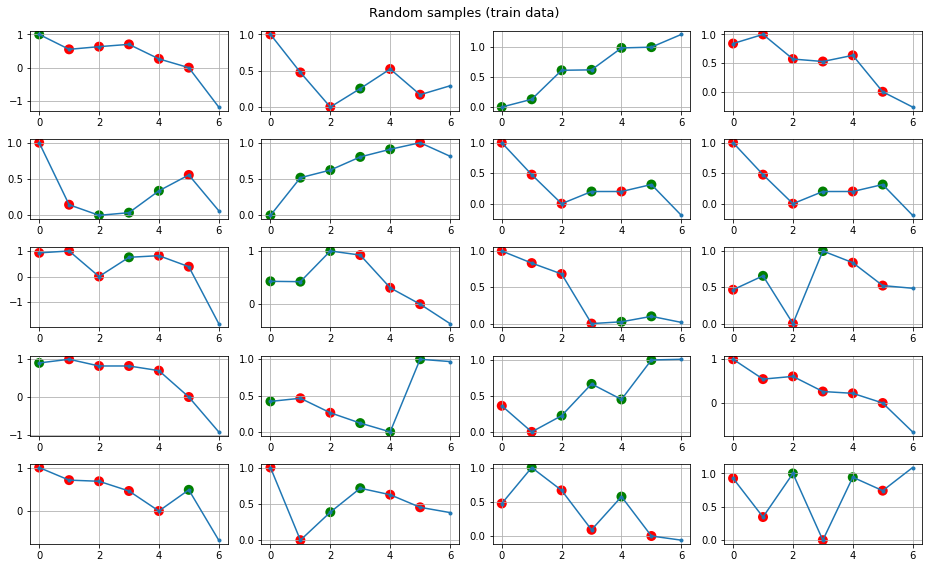

In [126]:
plt.figure(figsize=(13,8))
plt.suptitle("Random samples (train data)", fontsize=13)
plots = []
for i in range(5):
    for j in range(4):
        ax = plt.subplot2grid((5,4), (i,j))
        idx = random.randint(0, train_x.shape[0]-1)
        colors = {0:'red', 1:'green'}
        all_series= np.concatenate((train_x[idx,:,0].reshape(-1,),train_y_reg[idx,0].reshape(-1,)))
        plt.scatter(np.arange(0,train_x.shape[1]), all_series[:-1], c=pd.Series( train_x[idx, :, 1]).map(colors).values, s=100, lw=0)
        ax.plot(all_series, '.-')
        ax.grid()
plt.tight_layout()
plt.show()

###

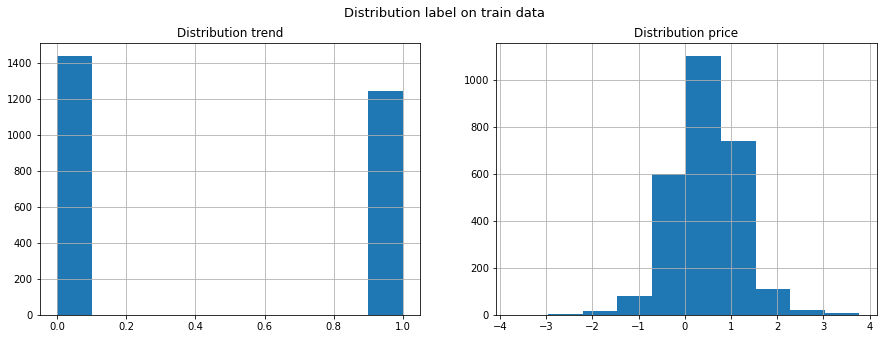

In [127]:
plt.figure(figsize=(15,5))
plt.suptitle("Distribution label on train data", fontsize=13)
plt.subplot(1,2,1)
plt.hist(train_y[:,0], )
plt.title("Distribution trend")
plt.grid()
plt.subplot(1,2,2)
plt.hist(train_y_reg[:,0], )
plt.title("Distribution price")
plt.grid()
plt.show()

## Model

### Auto-Encoder

#### Auto-Encoder Model

In [159]:
model_AutoEncoder = ml.Auto_Encoder(
    input_size=train_x.shape[2],
    nb_channel_conv=12
    )
model_AutoEncoder.to(device)
model_AutoEncoder

Auto_Encoder(
  (relu): LeakyReLU(negative_slope=0.01)
  (conv1): Conv1d(34, 12, kernel_size=(3,), stride=(1,))
  (conv2): Conv1d(12, 12, kernel_size=(3,), stride=(1,))
  (conv3): Conv1d(12, 12, kernel_size=(2,), stride=(1,))
  (conv1_t): ConvTranspose1d(12, 12, kernel_size=(2,), stride=(1,))
  (conv2_t): ConvTranspose1d(12, 12, kernel_size=(3,), stride=(1,))
  (conv3_t): ConvTranspose1d(12, 34, kernel_size=(3,), stride=(1,))
)

 22%|██▏       | 11/50 [00:01<00:05,  6.67it/s]

Epoch: 10/50
MSE = [train loss mean :  0.11200036] , [val loss mean:  0.12111090, MSE (last) 11.94128%]


 42%|████▏     | 21/50 [00:03<00:05,  5.50it/s]

Epoch: 20/50
MSE = [train loss mean :  0.10979095] , [val loss mean:  0.11945846, MSE (last) 11.94641%]


 62%|██████▏   | 31/50 [00:04<00:02,  6.68it/s]

Epoch: 30/50
MSE = [train loss mean :  0.10977590] , [val loss mean:  0.11942489, MSE (last) 11.94074%]


 82%|████████▏ | 41/50 [00:06<00:01,  6.74it/s]

Epoch: 40/50
MSE = [train loss mean :  0.10981803] , [val loss mean:  0.11944120, MSE (last) 11.94287%]


100%|██████████| 50/50 [00:07<00:00,  6.55it/s]


Epoch: 50/50
MSE = [train loss mean :  0.10983714] , [val loss mean:  0.11940831, MSE (last) 11.93435%]


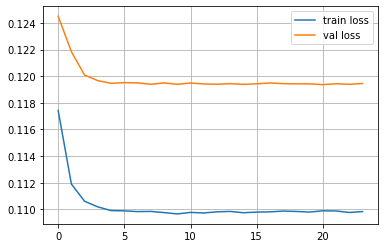

In [161]:
lr= 0.001
num_epochs= 50

train_loss, val_loss = pl.train(
    model=model_AutoEncoder,
    train_x_ = np.swapaxes(train_x,1,2),
    train_y_ =  np.swapaxes(train_x,1,2),
    val_x_ = np.swapaxes(val_x,1,2),
    val_y_=  np.swapaxes(val_x,1,2),
    batch_size_=512,
    num_epochs_=num_epochs,
    lr_=lr,
    device_=device,
    verbose = 1)
    
chunksize= int(num_epochs/20)
plt.plot(pl.smooth_loss(train_loss, chunksize = chunksize)[0:] , label="train loss")
plt.plot(pl.smooth_loss(val_loss, chunksize = chunksize)[0:] , label="val loss")
plt.legend()
plt.grid()
plt.show() #4.77938%


MSE:  0.11927


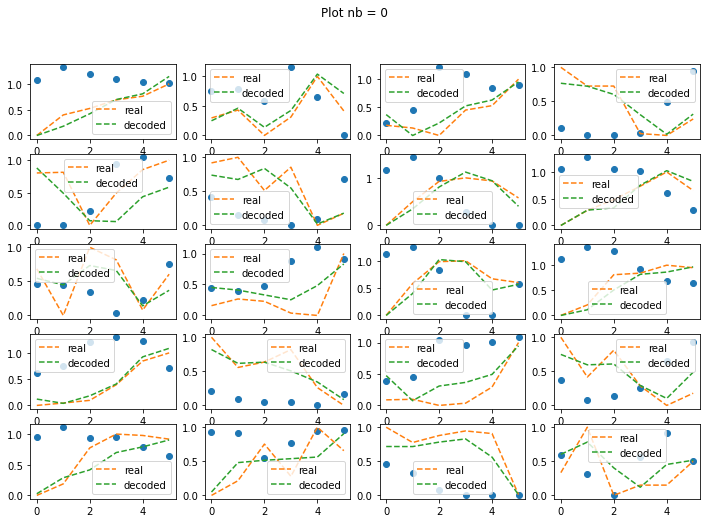

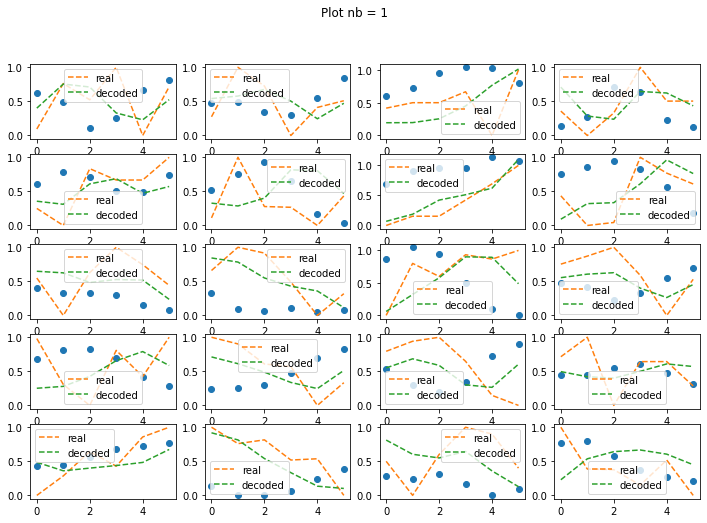

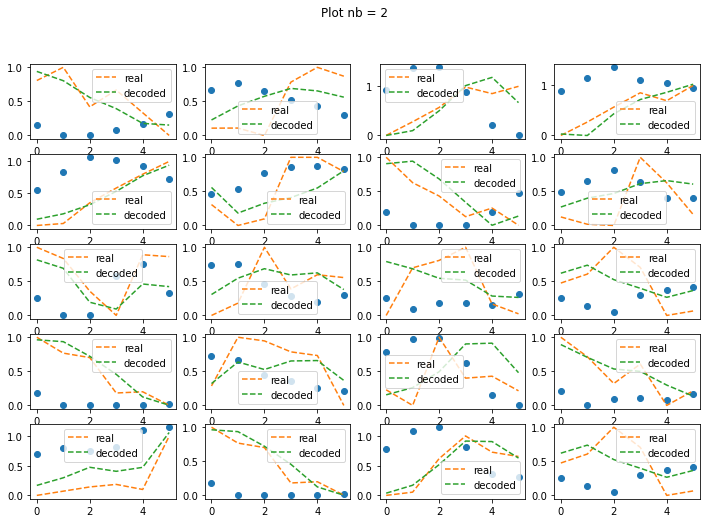

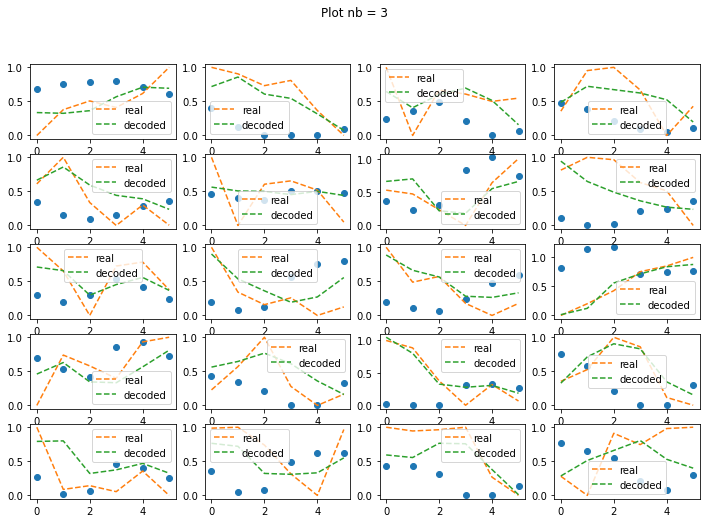

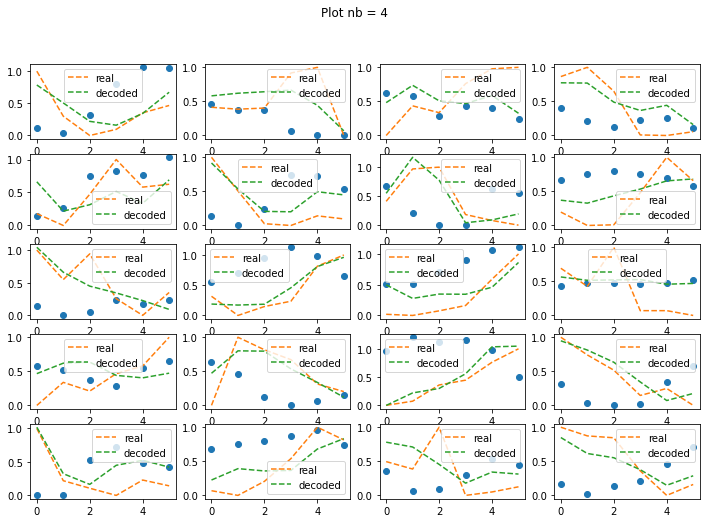

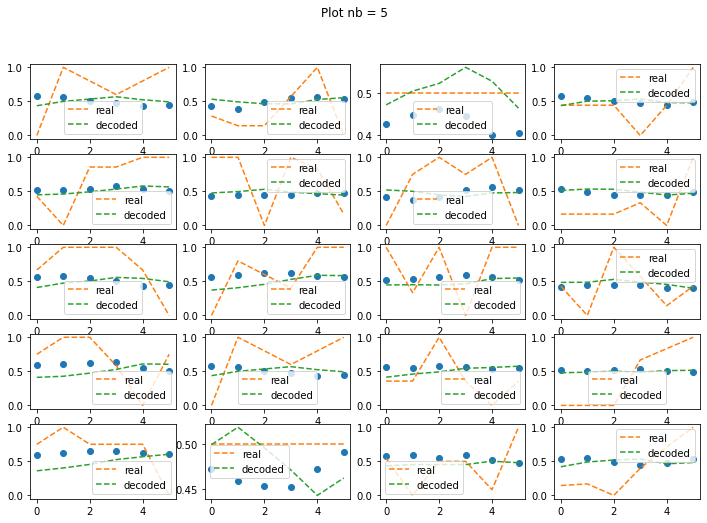

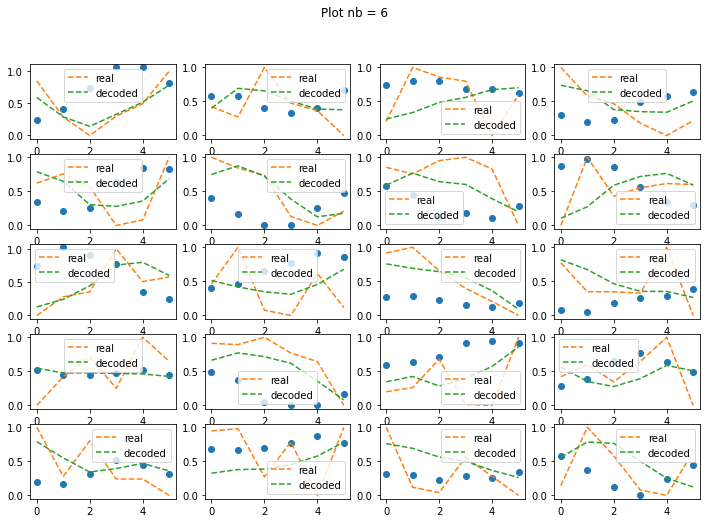

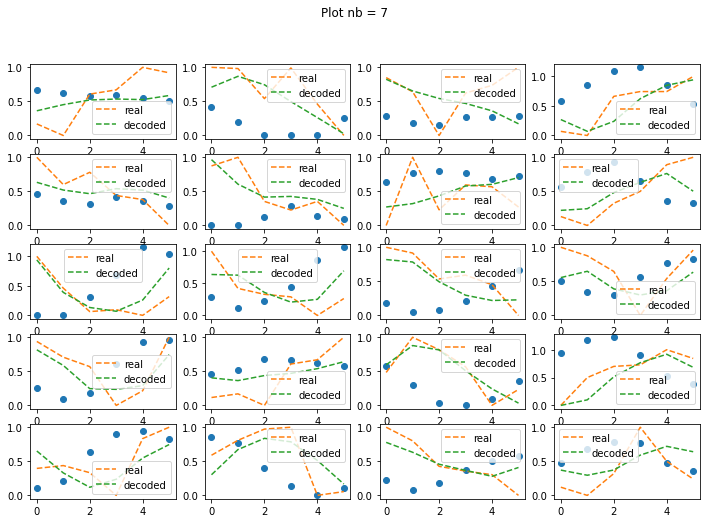

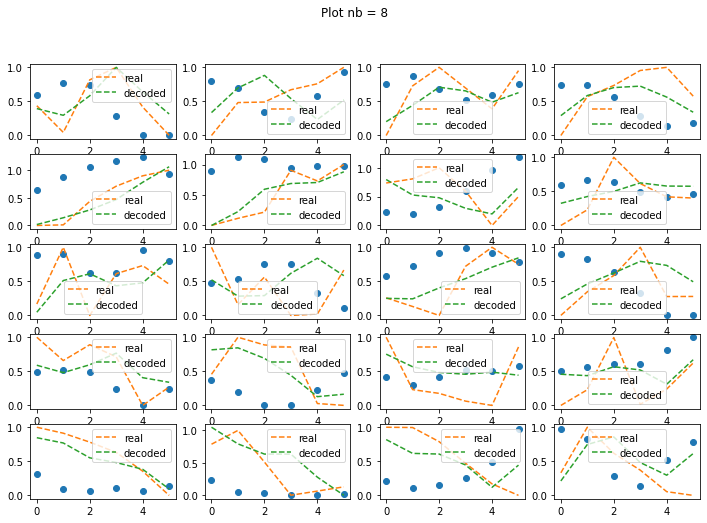

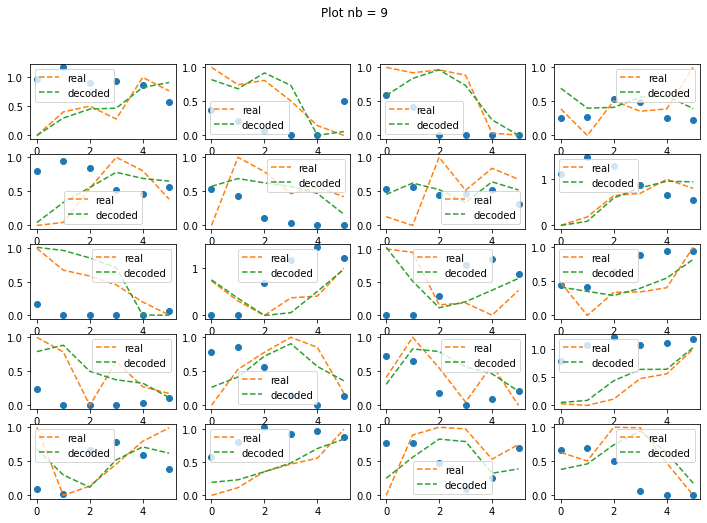

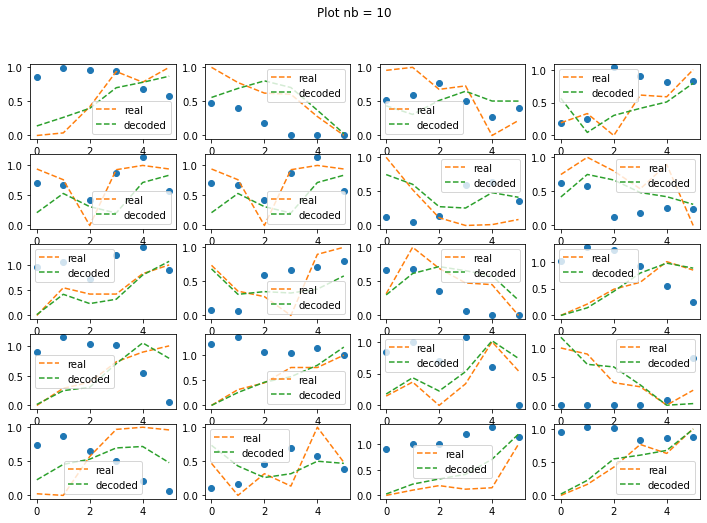

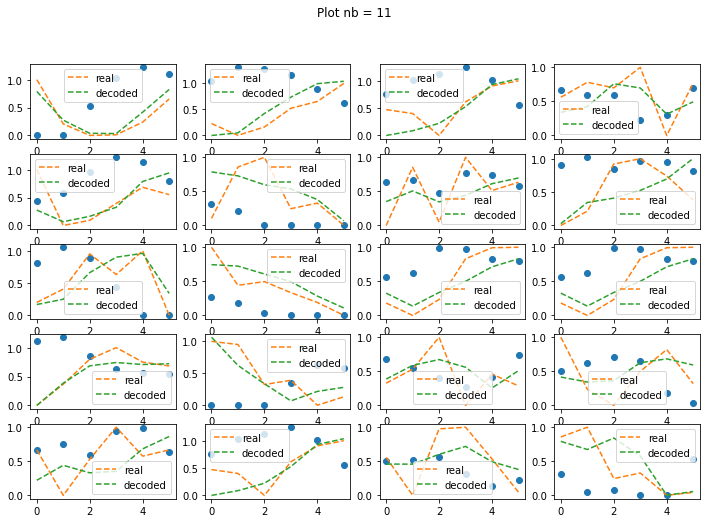

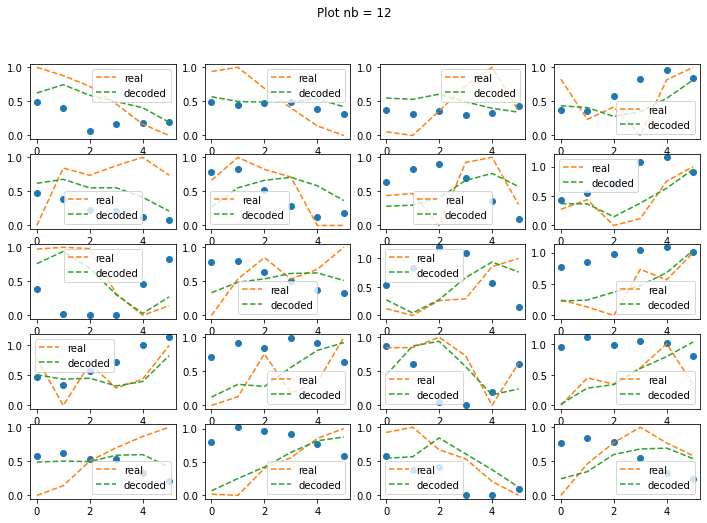

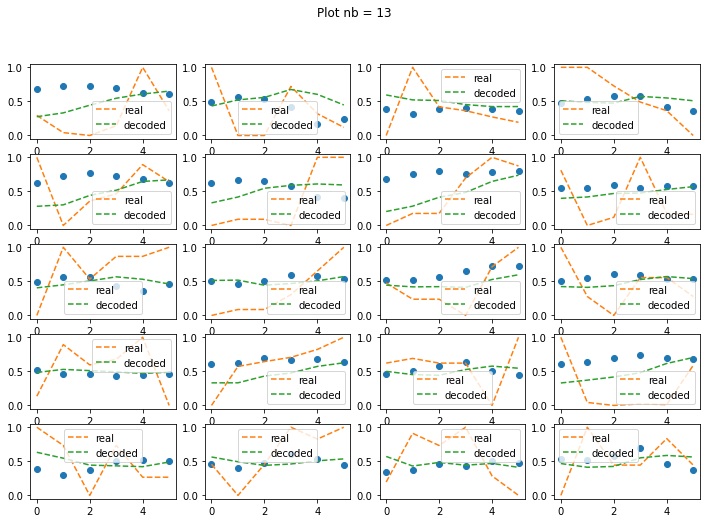

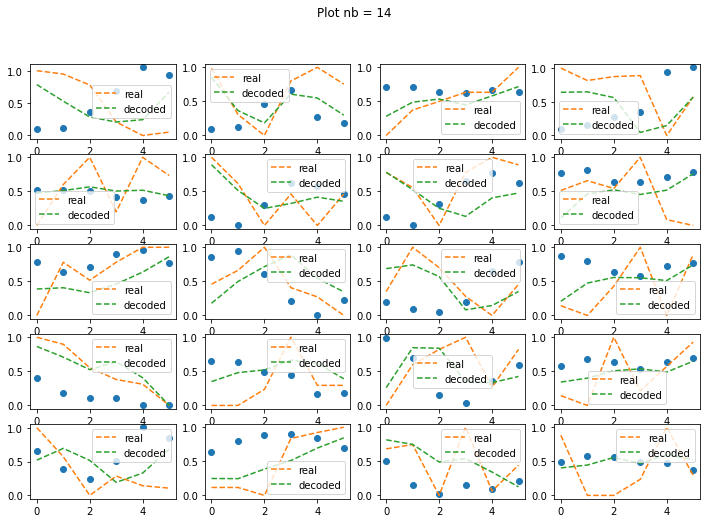

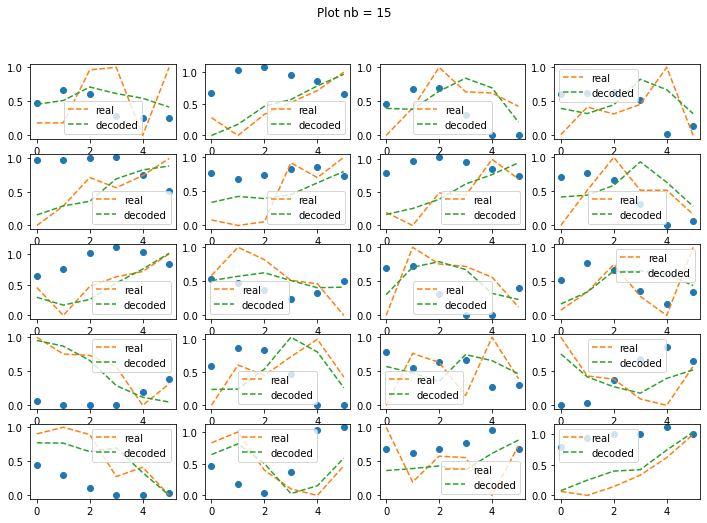

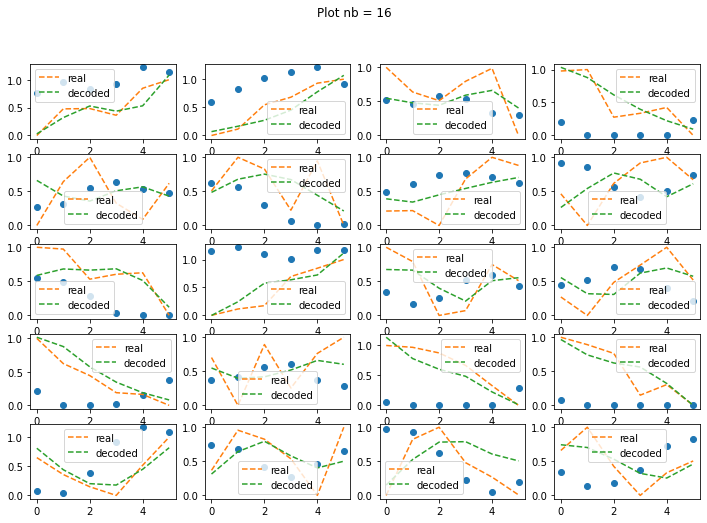

In [162]:
outputs_autoenc, targets, MSE = pl.evaluate(model_AutoEncoder, np.swapaxes(test_x,1,2), np.swapaxes(test_x,1,2), device='cpu') 

for p in range(17):
    plt.figure(figsize=(12,8))
    plt.suptitle("Plot nb = " + str(p))
    plots = []
    for i in range(5):
        for j in range(4):
            ax = plt.subplot2grid((5,4), (i,j))
            idx = random.randint(0, test_x.shape[0]-1)
           
            ax.plot(outputs_autoenc[idx,p*2+1,:], 'o')
            ax.plot(test_x[idx,:,p*2], '--', label= "real")
            ax.plot(outputs_autoenc[idx,p*2,:], '--', label= "decoded")

            #ax.plot(test_x[idx,:,0], '--', label= "real")
            #ax.plot(outputs_autoenc[idx, 0, :], '-o', label = "decoded")
            ax.legend()
    plt.show() 

In [163]:
torch.save(model_AutoEncoder.cpu().state_dict(), 'Helper/model/model_AutoEncoder.pth')

#### Apply Auto-Encoder to the dataset 

In [466]:
model_AutoEncoder = ml.Auto_Encoder(
    input_size=train_x.shape[2],
    nb_channel_conv=12
    )
model_AutoEncoder.load_state_dict(torch.load('Helper/model/model_AutoEncoder.pth'))
model_AutoEncoder.to(device)
model_AutoEncoder

Auto_Encoder(
  (relu): LeakyReLU(negative_slope=0.01)
  (conv1): Conv1d(34, 12, kernel_size=(3,), stride=(1,))
  (conv2): Conv1d(12, 12, kernel_size=(3,), stride=(1,))
  (conv3): Conv1d(12, 12, kernel_size=(2,), stride=(1,))
  (conv1_t): ConvTranspose1d(12, 12, kernel_size=(2,), stride=(1,))
  (conv2_t): ConvTranspose1d(12, 12, kernel_size=(3,), stride=(1,))
  (conv3_t): ConvTranspose1d(12, 34, kernel_size=(3,), stride=(1,))
)

In [467]:
model_AutoEncoder.eval()
inp1 = torch.from_numpy(np.swapaxes(train_x,1,2))
out = model_AutoEncoder(inp1.to(device).float())
train_x_smooth = np.swapaxes(out.cpu().detach().numpy(),2,1)

inp2 = torch.from_numpy(np.swapaxes(val_x,1,2))
out = model_AutoEncoder(inp2.to(device).float())
val_x_smooth = np.swapaxes(out.cpu().detach().numpy(),2,1)

inp3 = torch.from_numpy(np.swapaxes(test_x,1,2))
out = model_AutoEncoder(inp3.to(device).float())
test_x_smooth = np.swapaxes(out.cpu().detach().numpy(),2,1)

### Price prediction

#### Baseline

##### Dense

In [381]:
model_Dense = ml.Dense(
    num_layers = 6,
    layer_size = 256,
    input_size = train_x.reshape(train_x.shape[0],-1).shape[1],
    output_size = 1,
    dropout=0.2)
model_Dense.to(device)
model_Dense

Dense(
  (net): Sequential(
    (0): Linear(in_features=204, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.2, inplace=False)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Dropout(p=0.2, inplace=False)
    (7): ReLU()
    (8): Linear(in_features=256, out_features=256, bias=True)
    (9): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Dropout(p=0.2, inplace=False)
    (11): ReLU()
    (12): Linear(in_features=256, out_features=256, bias=True)
    (13): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): Dropout(p=0.2, inplace=False)
    (15): ReLU()
    (16): Linear(in_features=256, out_features=256, bias=True)
    (17): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_runn

 20%|██        | 201/1000 [00:34<02:27,  5.41it/s]

Epoch: 200/1000
MSE = [train loss mean :  0.56331718] , [val loss mean:  0.25658282, MSE (last) 17.83834%]


 39%|███▉      | 391/1000 [01:06<01:43,  5.89it/s]


0.15388155579566956 < 0.15374114513397216
Epoch: 392/1000
MSE = [train loss mean :  0.26163613] , [val loss mean:  0.16248930, MSE (last) 15.38081%]


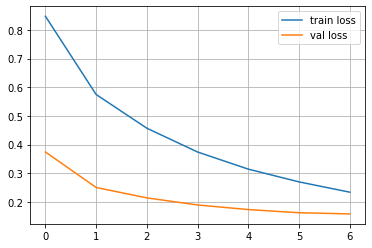

In [382]:
lr= 0.0001
num_epochs= 1000

train_loss, val_loss = pl.train(
    model=model_Dense,
    train_x_ = train_x.reshape(train_x.shape[0],-1),
    train_y_ =  train_y_reg[:,0].reshape(-1,1),
    val_x_ = val_x.reshape(val_x.shape[0],-1),
    val_y_=  val_y_reg[:,0].reshape(-1, 1),
    batch_size_=512,
    num_epochs_=num_epochs,
    lr_=lr,
    device_=device,
    verbose = 1)
    
chunksize= int(num_epochs/20)
plt.plot(pl.smooth_loss(train_loss, chunksize = chunksize)[0:] , label="train loss")
plt.plot(pl.smooth_loss(val_loss, chunksize = chunksize)[0:] , label="val loss")
plt.legend()
plt.grid()
plt.show() 


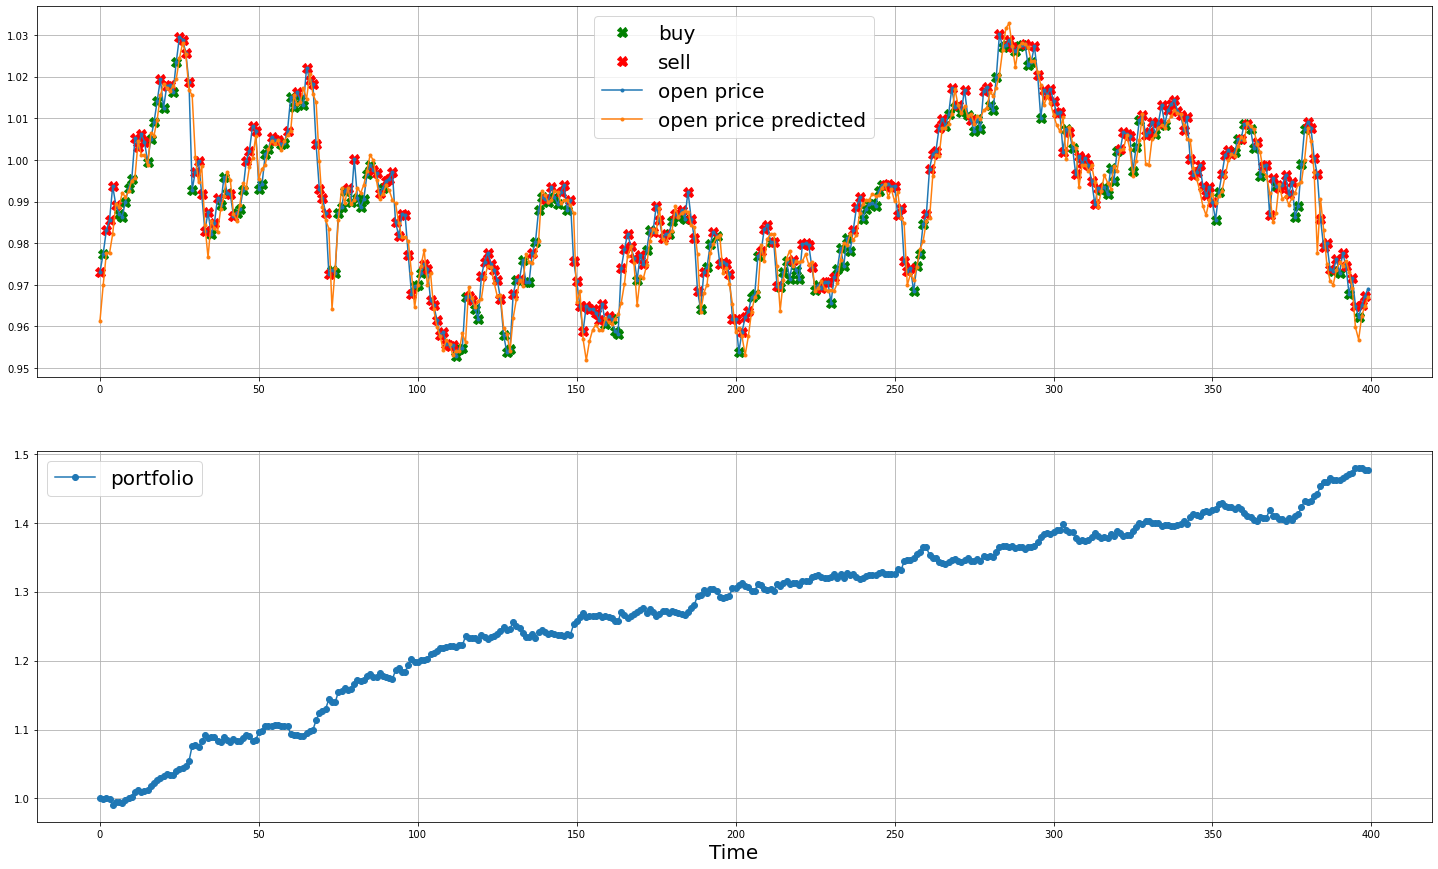

MSE           0.000084
ACC           0.679487
MEAN RET %    0.098465
Name: Dense, dtype: float64

In [552]:
outputs_Dense, targets, MSE = pl.evaluate(model_Dense, test_x.reshape(test_x.shape[0],-1), test_y_reg[:,0].reshape(-1,1), device=device) 

tuple_min_max= norm[2]
outputs_Dense = pp.min_max_norm_inverse(outputs_Dense.reshape(-1,), tuple_min_max_=tuple_min_max) 
t = pp.min_max_norm_inverse(targets.reshape(-1,), tuple_min_max_=tuple_min_max)

MSE_Dense = np.mean((outputs_Dense-t)**2)
ACC_Dense = pl.direction_accuracy(outputs_Dense, t)
MEAN_RET_Dense = pl.evauate_strategy(t, outputs_Dense,plot=True)

result_price_df['Dense'] = [MSE_Dense, ACC_Dense, MEAN_RET_Dense]
result_price_df['Dense']

##### LSTM

In [402]:
model_LSTM = ml.LSTM_base(
        hidden_size=16,
        num_layers=2,
        input_size= train_x.shape[2],
        out_features_lin=16,
        out_features_end=1,
        dropout=0.05,
        device=device)
model_LSTM.to(device)
model_LSTM

LSTM_base(
  (lstm): LSTM(34, 16, num_layers=2, batch_first=True, dropout=0.05)
  (fc0_bn): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_0): Linear(in_features=16, out_features=16, bias=True)
  (fc1_bn): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_1): Linear(in_features=16, out_features=1, bias=True)
  (relu): LeakyReLU(negative_slope=0.01)
)

 20%|██        | 201/1000 [00:16<01:19, 10.09it/s]

Epoch: 200/1000
MSE = [train loss mean :  0.39218629] , [val loss mean:  0.36959018, MSE (last) 23.41969%]


 40%|████      | 402/1000 [00:34<00:48, 12.40it/s]

Epoch: 400/1000
MSE = [train loss mean :  0.20683755] , [val loss mean:  0.21900262, MSE (last) 20.99909%]


 58%|█████▊    | 576/1000 [00:48<00:36, 11.76it/s]


0.20053732722997666 < 0.2005441665649414
Epoch: 577/1000
MSE = [train loss mean :  0.17854574] , [val loss mean:  0.20434832, MSE (last) 20.01140%]


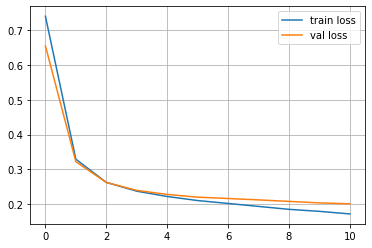

In [403]:
lr= 0.0001
num_epochs= 1000

train_loss, val_loss = pl.train(
    model=model_LSTM,
    train_x_ = train_x,
    train_y_ =  train_y_reg[:,0].reshape(-1,1),
    val_x_ = val_x,
    val_y_=  val_y_reg[:,0].reshape(-1, 1),
    batch_size_=512,
    num_epochs_=num_epochs,
    lr_=lr,
    device_=device,
    verbose = 1)
    
chunksize= int(num_epochs/20)
plt.plot(pl.smooth_loss(train_loss, chunksize = chunksize)[0:] , label="train loss")
plt.plot(pl.smooth_loss(val_loss, chunksize = chunksize)[0:] , label="val loss")
plt.legend()
plt.grid()
plt.show() 


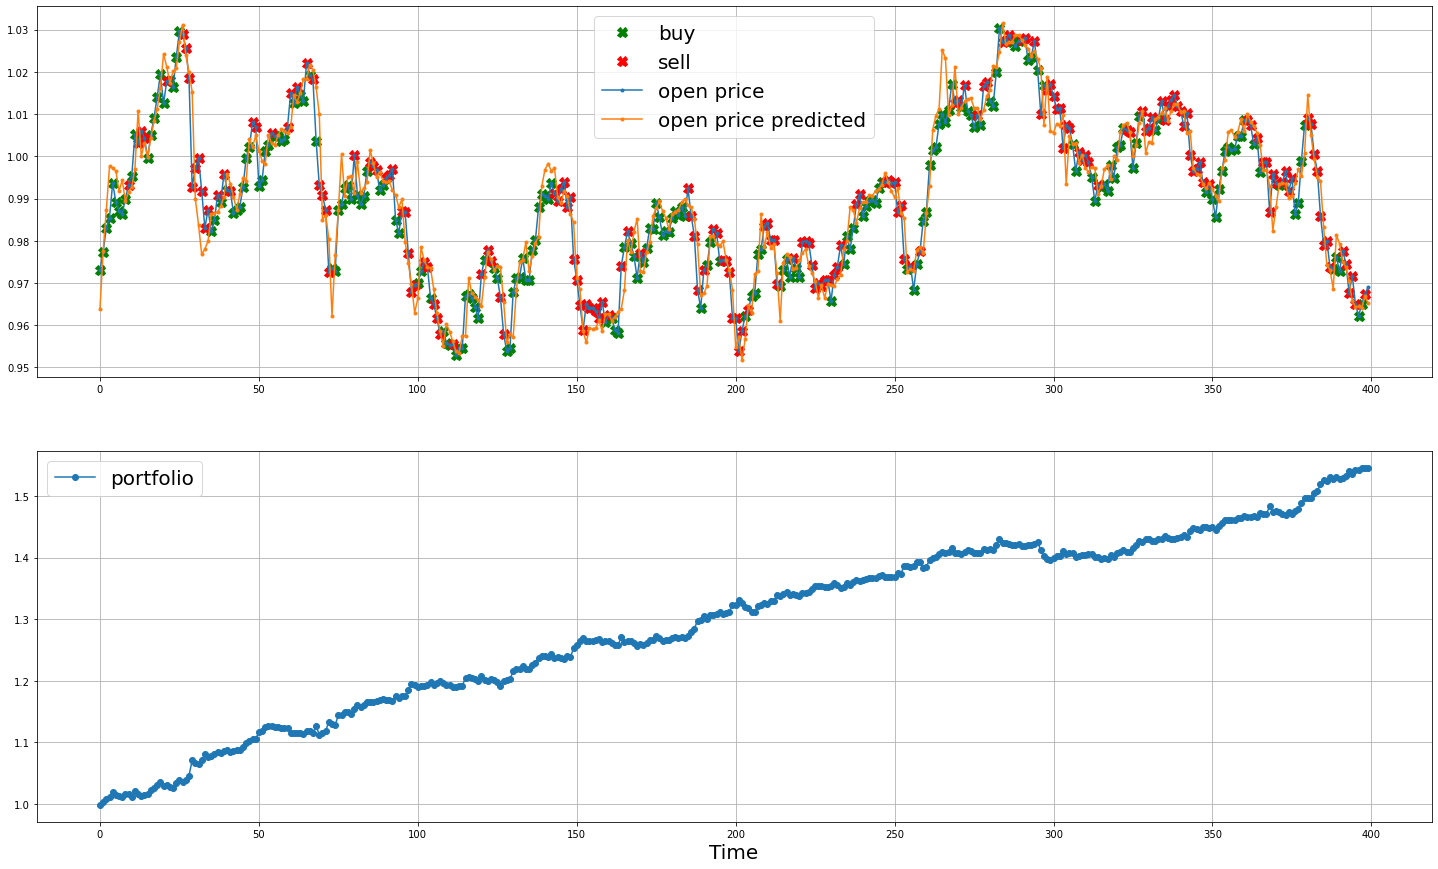

MSE           0.000079
ACC           0.685185
MEAN RET %    0.110107
Name: LSTM, dtype: float64

In [553]:
outputs_LSTM, targets, MSE = pl.evaluate(model_LSTM, test_x, test_y_reg[:,0].reshape(-1,1), device=device) 

tuple_min_max= norm[2]
outputs_LSTM = pp.min_max_norm_inverse(outputs_LSTM.reshape(-1,), tuple_min_max_=tuple_min_max) 
t = pp.min_max_norm_inverse(targets.reshape(-1,), tuple_min_max_=tuple_min_max)

MSE_LSTM = np.mean((outputs_LSTM-t)**2)
ACC_LSTM = pl.direction_accuracy(outputs_LSTM, t)
MEAN_RET_LSTM = pl.evauate_strategy(t, outputs_LSTM,plot=True)

result_price_df['LSTM'] = [MSE_LSTM, ACC_LSTM, MEAN_RET_LSTM]
result_price_df['LSTM']

##### GRU 

In [408]:
model_GRU = ml.GRU_base(
        hidden_size=32,
        num_layers=2,
        input_size= train_x.shape[2],
        out_features_lin=32,
        out_features_end=1,
        dropout=0.05,
        device=device)
model_GRU.to(device)
model_GRU

GRU_base(
  (gru): GRU(34, 32, num_layers=2, batch_first=True, dropout=0.05)
  (fc0_bn): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_0): Linear(in_features=32, out_features=32, bias=True)
  (fc1_bn): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_1): Linear(in_features=32, out_features=1, bias=True)
  (relu): LeakyReLU(negative_slope=0.01)
)

 20%|██        | 201/1000 [00:25<01:39,  8.02it/s]

Epoch: 200/1000
MSE = [train loss mean :  0.35639065] , [val loss mean:  0.34913606, MSE (last) 21.83029%]


 26%|██▌       | 261/1000 [00:33<01:33,  7.90it/s]


0.21501481622457505 < 0.21505980372428893
Epoch: 262/1000
MSE = [train loss mean :  0.21865463] , [val loss mean:  0.23806689, MSE (last) 21.45290%]


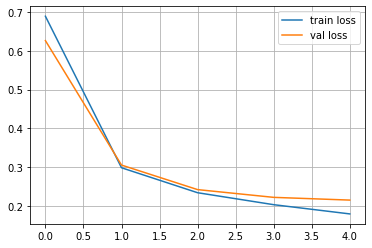

In [409]:
lr= 0.0001
num_epochs= 1000

train_loss, val_loss = pl.train(
    model=model_GRU,
    train_x_ = train_x,
    train_y_ =  train_y_reg[:,0].reshape(-1,1),
    val_x_ = val_x,
    val_y_=  val_y_reg[:,0].reshape(-1, 1),
    batch_size_=512,
    num_epochs_=num_epochs,
    lr_=lr,
    device_=device,
    verbose = 1)
    
chunksize= int(num_epochs/20)
plt.plot(pl.smooth_loss(train_loss, chunksize = chunksize)[0:] , label="train loss")
plt.plot(pl.smooth_loss(val_loss, chunksize = chunksize)[0:] , label="val loss")
plt.legend()
plt.grid()
plt.show() 

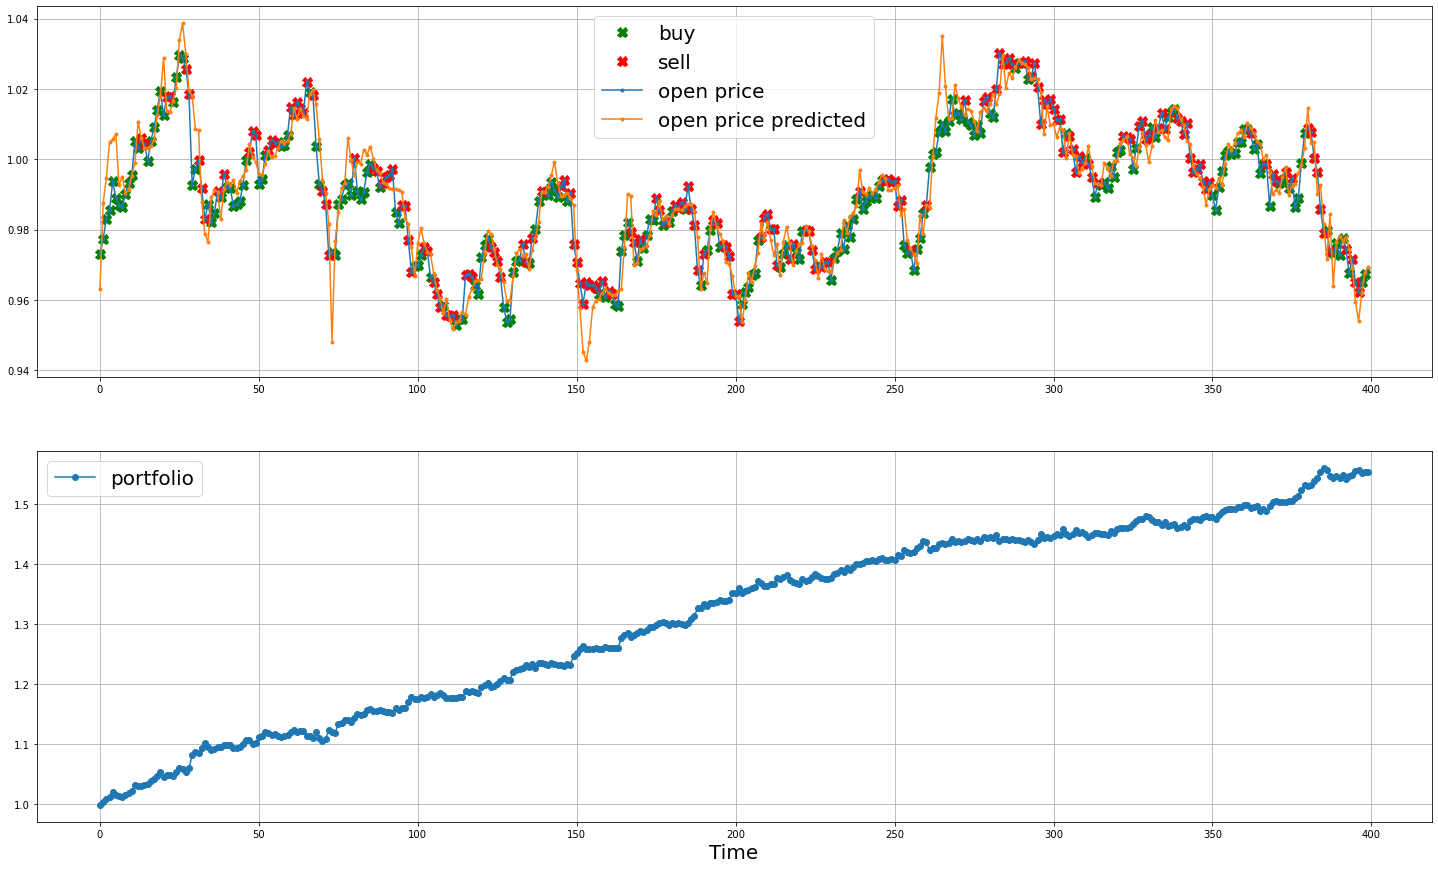

MSE           0.000115
ACC           0.713675
MEAN RET %    0.111509
Name: GRU, dtype: float64

In [554]:
outputs_GRU, targets, MSE = pl.evaluate(model_GRU, test_x, test_y_reg[:,0].reshape(-1,1), device=device) 

tuple_min_max= norm[2]
outputs_GRU = pp.min_max_norm_inverse(outputs_GRU.reshape(-1,), tuple_min_max_=tuple_min_max) 
t = pp.min_max_norm_inverse(targets.reshape(-1,), tuple_min_max_=tuple_min_max)

MSE_GRU = np.mean((outputs_GRU-t)**2)
ACC_GRU = pl.direction_accuracy(outputs_GRU, t)
MEAN_RET_GRU = pl.evauate_strategy(t, outputs_GRU, plot=True)

result_price_df['GRU'] = [MSE_GRU, ACC_GRU, MEAN_RET_GRU]
result_price_df['GRU']

#### Add Auto-Encoder 

##### Dense + AE

In [430]:
model_Dense_AE = ml.Dense(
    num_layers = 6,
    layer_size = 256,
    input_size = train_x.reshape(train_x.shape[0],-1).shape[1],
    output_size = 1,
    dropout=0.2)
model_Dense_AE.to(device)
model_Dense_AE

Dense(
  (net): Sequential(
    (0): Linear(in_features=204, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.2, inplace=False)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Dropout(p=0.2, inplace=False)
    (7): ReLU()
    (8): Linear(in_features=256, out_features=256, bias=True)
    (9): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Dropout(p=0.2, inplace=False)
    (11): ReLU()
    (12): Linear(in_features=256, out_features=256, bias=True)
    (13): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): Dropout(p=0.2, inplace=False)
    (15): ReLU()
    (16): Linear(in_features=256, out_features=256, bias=True)
    (17): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_runn

 20%|██        | 201/1000 [00:32<02:04,  6.41it/s]

Epoch: 200/1000
MSE = [train loss mean :  0.50389801] , [val loss mean:  0.20081496, MSE (last) 16.60926%]


 27%|██▋       | 269/1000 [00:44<01:59,  6.11it/s]


0.16207824051380157 < 0.1621413856744766
Epoch: 270/1000
MSE = [train loss mean :  0.37155691] , [val loss mean:  0.17520153, MSE (last) 16.28595%]


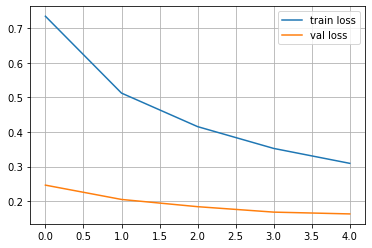

In [431]:
lr= 0.0001
num_epochs= 1000

train_loss, val_loss = pl.train(
    model=model_Dense_AE,
    train_x_ = train_x_smooth.reshape(train_x_smooth.shape[0],-1),
    train_y_ =  train_y_reg[:,0].reshape(-1,1),
    val_x_ = val_x_smooth.reshape(val_x_smooth.shape[0],-1),
    val_y_=  val_y_reg[:,0].reshape(-1, 1),
    batch_size_=512,
    num_epochs_=num_epochs,
    lr_=lr,
    device_=device,
    verbose = 1)
    
chunksize= int(num_epochs/20)
plt.plot(pl.smooth_loss(train_loss, chunksize = chunksize)[0:] , label="train loss")
plt.plot(pl.smooth_loss(val_loss, chunksize = chunksize)[0:] , label="val loss")
plt.legend()
plt.grid()
plt.show() 

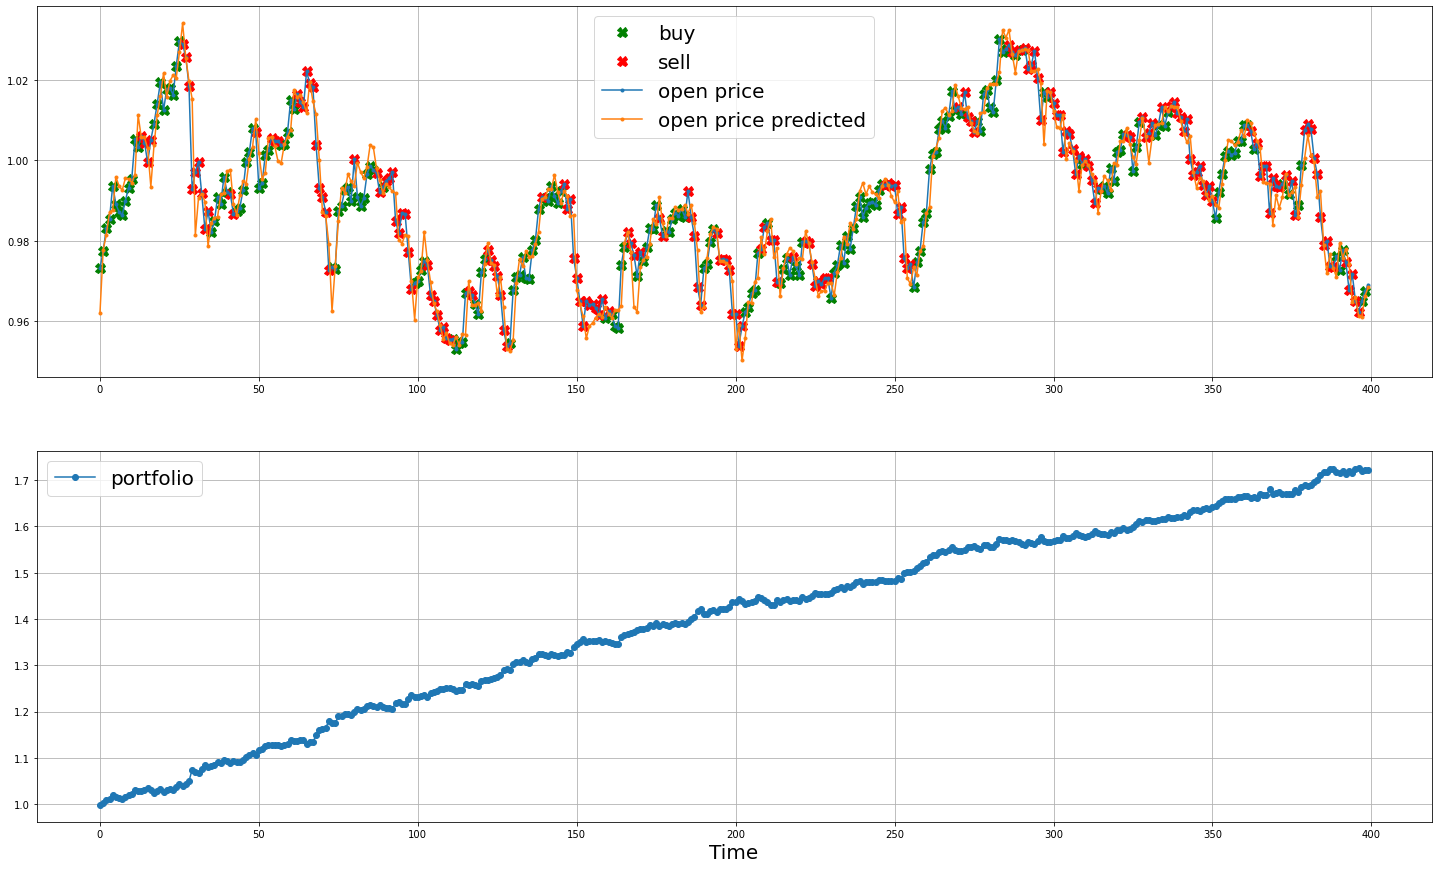

MSE           0.000129
ACC           0.678063
MEAN RET %    0.137447
Name: Dense_AE, dtype: float64

In [556]:
outputs_Dense_AE, targets, MSE = pl.evaluate(model_Dense_AE, test_x_smooth.reshape(test_x_smooth.shape[0],-1), test_y_reg[:,0].reshape(-1,1), device=device) 

tuple_min_max= norm[2]
outputs_Dense_AE = pp.min_max_norm_inverse(outputs_Dense_AE.reshape(-1,), tuple_min_max_=tuple_min_max) 
t = pp.min_max_norm_inverse(targets.reshape(-1,), tuple_min_max_=tuple_min_max)

MSE_Dense_AE = np.mean((outputs_Dense_AE-t)**2)
ACC_Dense_AE = pl.direction_accuracy(outputs_Dense_AE, t)
MEAN_RET_Dense_AE = pl.evauate_strategy(t, outputs_Dense_AE, plot=True)

result_price_df['Dense_AE'] = [MSE_Dense_AE, ACC_Dense_AE, MEAN_RET_Dense_AE]
result_price_df['Dense_AE']

##### LSTM + AE

In [495]:
model_LSTM_AE = ml.LSTM_base(
        hidden_size=16,
        num_layers=2,
        input_size= train_x.shape[2],
        out_features_lin=16,
        out_features_end=1,
        dropout=0.1,
        device=device)
model_LSTM_AE.to(device)
model_LSTM_AE

LSTM_base(
  (lstm): LSTM(34, 16, num_layers=2, batch_first=True, dropout=0.1)
  (fc0_bn): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_0): Linear(in_features=16, out_features=16, bias=True)
  (fc1_bn): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_1): Linear(in_features=16, out_features=1, bias=True)
  (relu): LeakyReLU(negative_slope=0.01)
)

 20%|██        | 202/1000 [00:18<01:07, 11.77it/s]

Epoch: 200/1000
MSE = [train loss mean :  0.51779756] , [val loss mean:  0.56381955, MSE (last) 20.87242%]


 40%|████      | 402/1000 [00:36<00:52, 11.50it/s]

Epoch: 400/1000
MSE = [train loss mean :  0.22760796] , [val loss mean:  0.18957979, MSE (last) 18.03873%]


 55%|█████▌    | 554/1000 [00:49<00:39, 11.26it/s]


0.1785067194700241 < 0.1785166996717453
Epoch: 555/1000
MSE = [train loss mean :  0.21699354] , [val loss mean:  0.18055723, MSE (last) 17.88721%]


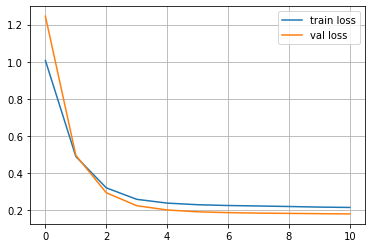

In [496]:
lr= 0.0001
num_epochs= 1000

train_loss, val_loss = pl.train(
    model=model_LSTM_AE,
    train_x_ = train_x_smooth,
    train_y_ =  train_y_reg[:,0].reshape(-1,1),
    val_x_ = val_x_smooth,
    val_y_=  val_y_reg[:,0].reshape(-1, 1),
    batch_size_=512,
    num_epochs_=num_epochs,
    lr_=lr,
    device_=device,
    verbose = 1)
    
chunksize= int(num_epochs/20)
plt.plot(pl.smooth_loss(train_loss, chunksize = chunksize)[0:] , label="train loss")
plt.plot(pl.smooth_loss(val_loss, chunksize = chunksize)[0:] , label="val loss")
plt.legend()
plt.grid()
plt.show() 

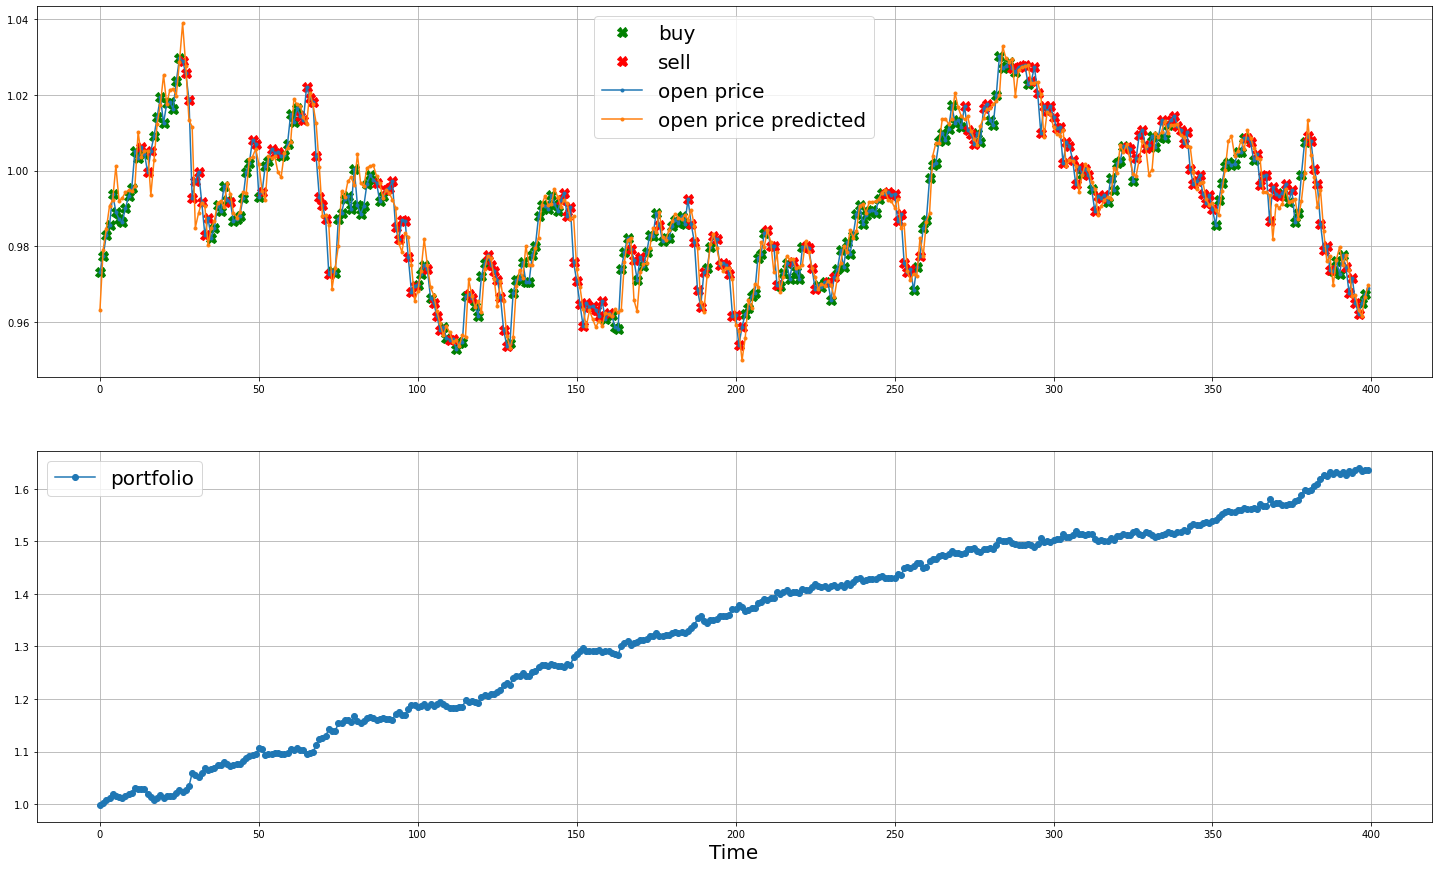

MSE           0.000126
ACC           0.676638
MEAN RET %    0.124539
Name: LSTM_AE, dtype: float64

In [557]:
outputs_LSTM_AE, targets, MSE = pl.evaluate(model_LSTM_AE, test_x_smooth, test_y_reg[:,0].reshape(-1,1), device=device) 

tuple_min_max= norm[2]
outputs_LSTM_AE = pp.min_max_norm_inverse(outputs_LSTM_AE.reshape(-1,), tuple_min_max_=tuple_min_max) 
t = pp.min_max_norm_inverse(targets.reshape(-1,), tuple_min_max_=tuple_min_max)

MSE_LSTM_AE = np.mean((outputs_LSTM_AE-t)**2)
ACC_LSTM_AE = pl.direction_accuracy(outputs_LSTM_AE, t)
MEAN_RET_LSTM_AE = pl.evauate_strategy(t, outputs_LSTM_AE,plot=True)

result_price_df['LSTM_AE'] = [MSE_LSTM_AE, ACC_LSTM_AE, MEAN_RET_LSTM_AE]
result_price_df['LSTM_AE']

##### GRU + AE

In [564]:
model_GRU_AE = ml.GRU_base(
        hidden_size=32,
        num_layers=2,
        input_size= train_x.shape[2],
        out_features_lin=32,
        out_features_end=1,
        dropout=0.1,
        device=device)
model_GRU_AE.to(device)
model_GRU_AE

GRU_base(
  (gru): GRU(34, 32, num_layers=2, batch_first=True, dropout=0.1)
  (fc0_bn): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_0): Linear(in_features=32, out_features=32, bias=True)
  (fc1_bn): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_1): Linear(in_features=32, out_features=1, bias=True)
  (relu): LeakyReLU(negative_slope=0.01)
)

 20%|██        | 201/1000 [00:27<01:43,  7.74it/s]

Epoch: 200/1000
MSE = [train loss mean :  0.30377489] , [val loss mean:  0.21468580, MSE (last) 17.00920%]


 32%|███▏      | 324/1000 [00:42<01:29,  7.59it/s]


0.1644384065270424 < 0.16445272564888
Epoch: 325/1000
MSE = [train loss mean :  0.21811935] , [val loss mean:  0.17006952, MSE (last) 16.46995%]


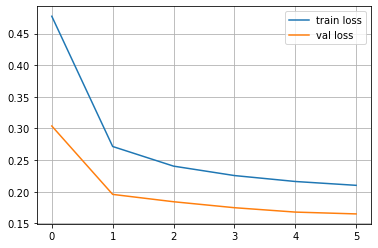

In [565]:
lr= 0.0001
num_epochs= 1000

train_loss, val_loss = pl.train(
    model=model_GRU_AE,
    train_x_ = train_x_smooth,
    train_y_ =  train_y_reg[:,0].reshape(-1,1),
    val_x_ = val_x_smooth,
    val_y_=  val_y_reg[:,0].reshape(-1, 1),
    batch_size_=512,
    num_epochs_=num_epochs,
    lr_=lr,
    device_=device,
    verbose = 1)
    
chunksize= int(num_epochs/20)
plt.plot(pl.smooth_loss(train_loss, chunksize = chunksize)[0:] , label="train loss")
plt.plot(pl.smooth_loss(val_loss, chunksize = chunksize)[0:] , label="val loss")
plt.legend()
plt.grid()
plt.show() 

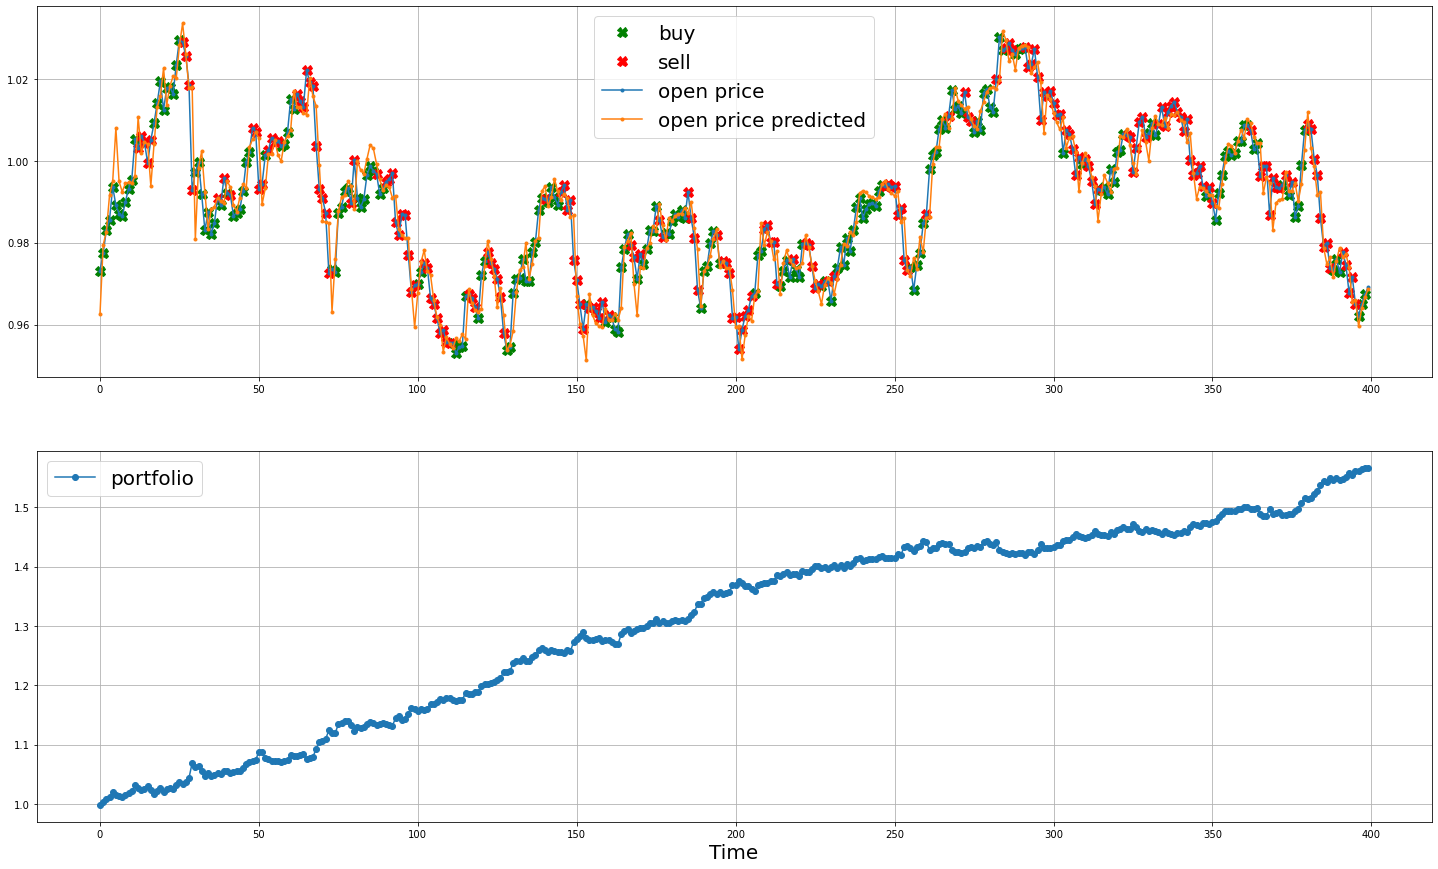

MSE           0.000127
ACC           0.682336
MEAN RET %    0.113620
Name: GRU_AE, dtype: float64

In [566]:
outputs_GRU_AE, targets, MSE = pl.evaluate(model_GRU_AE, test_x_smooth, test_y_reg[:,0].reshape(-1,1), device=device) 

tuple_min_max= norm[2]
outputs_GRU_AE = pp.min_max_norm_inverse(outputs_GRU_AE.reshape(-1,), tuple_min_max_=tuple_min_max) 
t = pp.min_max_norm_inverse(targets.reshape(-1,), tuple_min_max_=tuple_min_max)

MSE_GRU_AE = np.mean((outputs_GRU_AE-t)**2)
ACC_GRU_AE = pl.direction_accuracy(outputs_GRU_AE, t)
MEAN_RET_GRU_AE = pl.evauate_strategy(t, outputs_GRU_AE, plot=True)

result_price_df['GRU_AE'] = [MSE_GRU_AE, ACC_GRU_AE, MEAN_RET_GRU_AE]
result_price_df['GRU_AE']

#### Add Regularized Loss: $L = \sum (y- \hat{y})^2 + \lambda \sum ((y- y_{prev})(y- \hat{y}))^2 $

##### Dense + AE + REG

In [512]:
model_Dense_AE_REG = ml.Dense(
    num_layers = 6,
    layer_size = 256,
    input_size = train_x.reshape(train_x.shape[0],-1).shape[1],
    output_size = 1,
    dropout=0.2)
model_Dense_AE_REG.to(device)
model_Dense_AE_REG

Dense(
  (net): Sequential(
    (0): Linear(in_features=204, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.2, inplace=False)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Dropout(p=0.2, inplace=False)
    (7): ReLU()
    (8): Linear(in_features=256, out_features=256, bias=True)
    (9): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Dropout(p=0.2, inplace=False)
    (11): ReLU()
    (12): Linear(in_features=256, out_features=256, bias=True)
    (13): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): Dropout(p=0.2, inplace=False)
    (15): ReLU()
    (16): Linear(in_features=256, out_features=256, bias=True)
    (17): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_runn

 17%|█▋        | 174/1000 [00:33<02:39,  5.19it/s]


0.17693493618684658 < 0.17695588336271398
Epoch: 175/1000
MSE = [train loss mean :  0.78180763] , [val loss mean:  0.32020447, MSE (last) 2439.52446%]


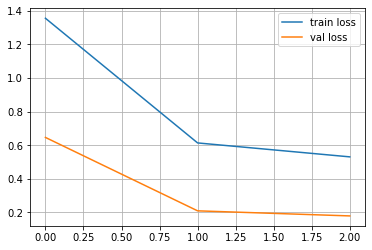

In [513]:
lr= 0.0001
num_epochs= 1000

train_loss, val_loss = pl.train_regularized(
    model=model_Dense_AE_REG,
    train_x_ = train_x_smooth.reshape(train_x_smooth.shape[0],-1),
    train_y_ =  train_y_reg[:,0].reshape(-1,1),
    val_x_ = val_x_smooth.reshape(val_x_smooth.shape[0],-1),
    val_y_=  val_y_reg[:,0].reshape(-1, 1),
    batch_size_=512,
    num_epochs_=num_epochs,
    lambda_=0.01,
    lr_=lr,
    device_=device,
    verbose = 1)
    
chunksize= int(num_epochs/20)
plt.plot(pl.smooth_loss(train_loss, chunksize = chunksize)[0:] , label="train loss")
plt.plot(pl.smooth_loss(val_loss, chunksize = chunksize)[0:] , label="val loss")
plt.legend()
plt.grid()
plt.show()

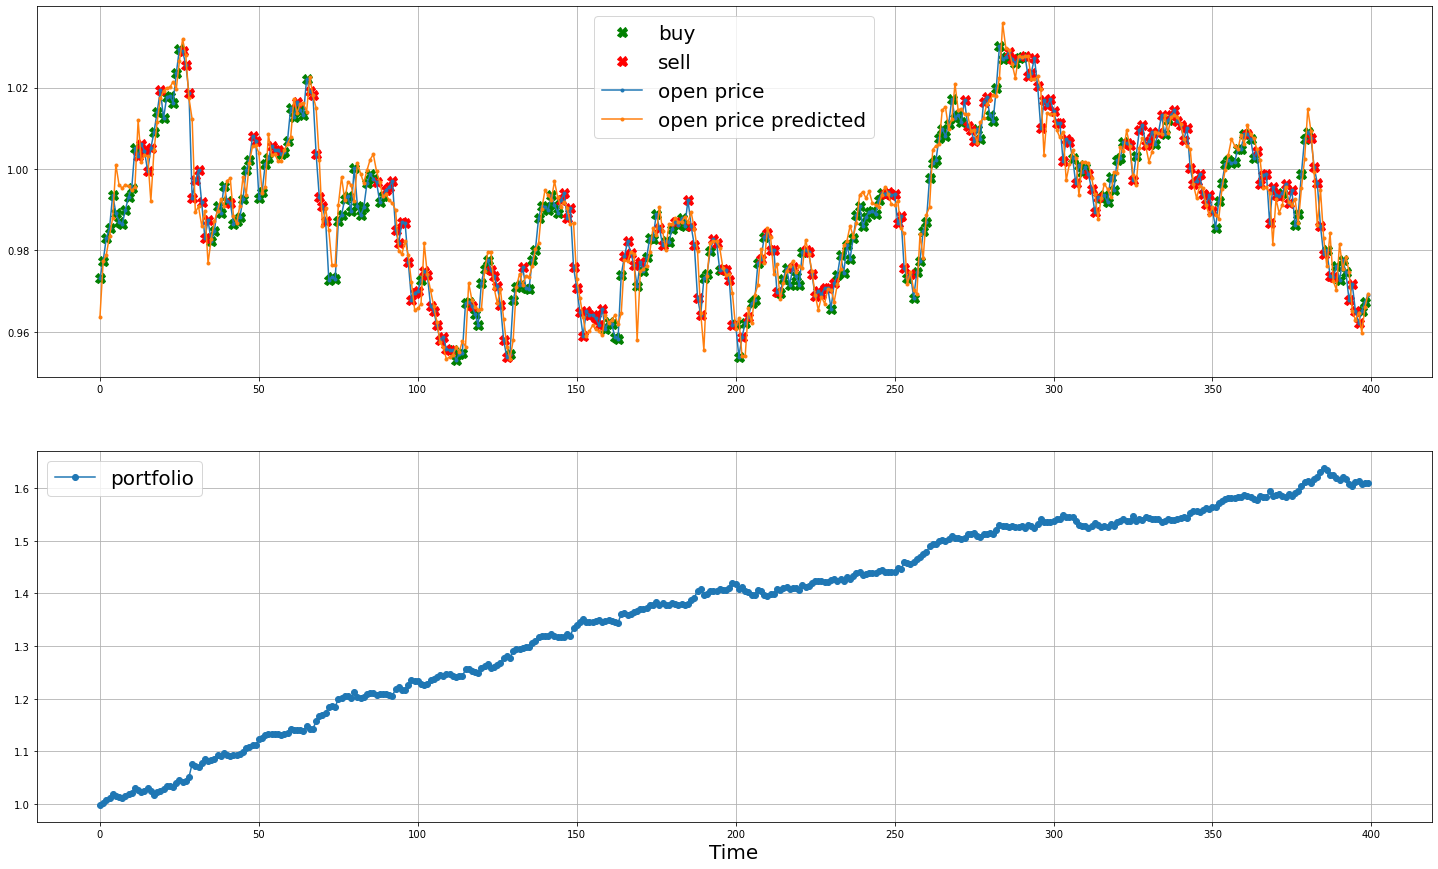

MSE           0.000124
ACC           0.678063
MEAN RET %    0.120484
Name: Dense_AE_REG, dtype: float64

In [568]:

outputs_Dense_AE_REG, targets, MSE = pl.evaluate(model_Dense_AE_REG, test_x_smooth.reshape(test_x_smooth.shape[0],-1), test_y_reg[:,0].reshape(-1,1), device=device) 

tuple_min_max= norm[2]
outputs_Dense_AE_REG = pp.min_max_norm_inverse(outputs_Dense_AE_REG.reshape(-1,), tuple_min_max_=tuple_min_max) 
t = pp.min_max_norm_inverse(targets.reshape(-1,), tuple_min_max_=tuple_min_max)

MSE_Dense_AE_REG = np.mean((outputs_Dense_AE_REG-t)**2)
ACC_Dense_AE_REG = pl.direction_accuracy(outputs_Dense_AE_REG, t)
MEAN_RET_Dense_AE_REG = pl.evauate_strategy(t, outputs_Dense_AE_REG,plot=True)

result_price_df['Dense_AE_REG'] = [MSE_Dense_AE_REG, ACC_Dense_AE_REG, MEAN_RET_Dense_AE_REG]
result_price_df['Dense_AE_REG']

##### LSTM + AE + REG

In [530]:
model_LSTM_AE_REG = ml.LSTM_base(
        hidden_size=16,
        num_layers=2,
        input_size= train_x.shape[2],
        out_features_lin=16,
        out_features_end=1,
        dropout=0.2,
        device=device)
model_LSTM_AE_REG.to(device)
model_LSTM_AE_REG

LSTM_base(
  (lstm): LSTM(34, 16, num_layers=2, batch_first=True, dropout=0.2)
  (fc0_bn): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_0): Linear(in_features=16, out_features=16, bias=True)
  (fc1_bn): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_1): Linear(in_features=16, out_features=1, bias=True)
  (relu): LeakyReLU(negative_slope=0.01)
)

 20%|██        | 202/1000 [00:21<01:16, 10.38it/s]

Epoch: 200/1000
MSE = [train loss mean :  0.40105822] , [val loss mean:  0.29729911, MSE (last) 2494.19670%]


 40%|████      | 402/1000 [00:40<00:54, 10.88it/s]

Epoch: 400/1000
MSE = [train loss mean :  0.23874221] , [val loss mean:  0.17581664, MSE (last) 2314.88190%]


 45%|████▌     | 454/1000 [00:45<00:54,  9.96it/s]


0.1698423696966732 < 0.16987192602718576
Epoch: 455/1000
MSE = [train loss mean :  0.23444229] , [val loss mean:  0.17271505, MSE (last) 2314.64787%]


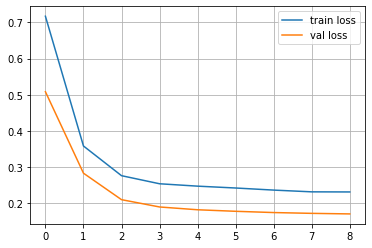

In [531]:
lr= 0.0001
num_epochs= 1000

train_loss, val_loss = pl.train_regularized(
    model=model_LSTM_AE_REG,
    train_x_ = train_x_smooth,
    train_y_ =  train_y_reg[:,0].reshape(-1,1),
    val_x_ = val_x_smooth,
    val_y_=  val_y_reg[:,0].reshape(-1, 1),
    batch_size_=512,
    num_epochs_=num_epochs,
    lr_=lr,
    lambda_=0.01,
    device_=device,
    verbose = 1)
    
chunksize= int(num_epochs/20)
plt.plot(pl.smooth_loss(train_loss, chunksize = chunksize)[0:] , label="train loss")
plt.plot(pl.smooth_loss(val_loss, chunksize = chunksize)[0:] , label="val loss")
plt.legend()
plt.grid()
plt.show() 

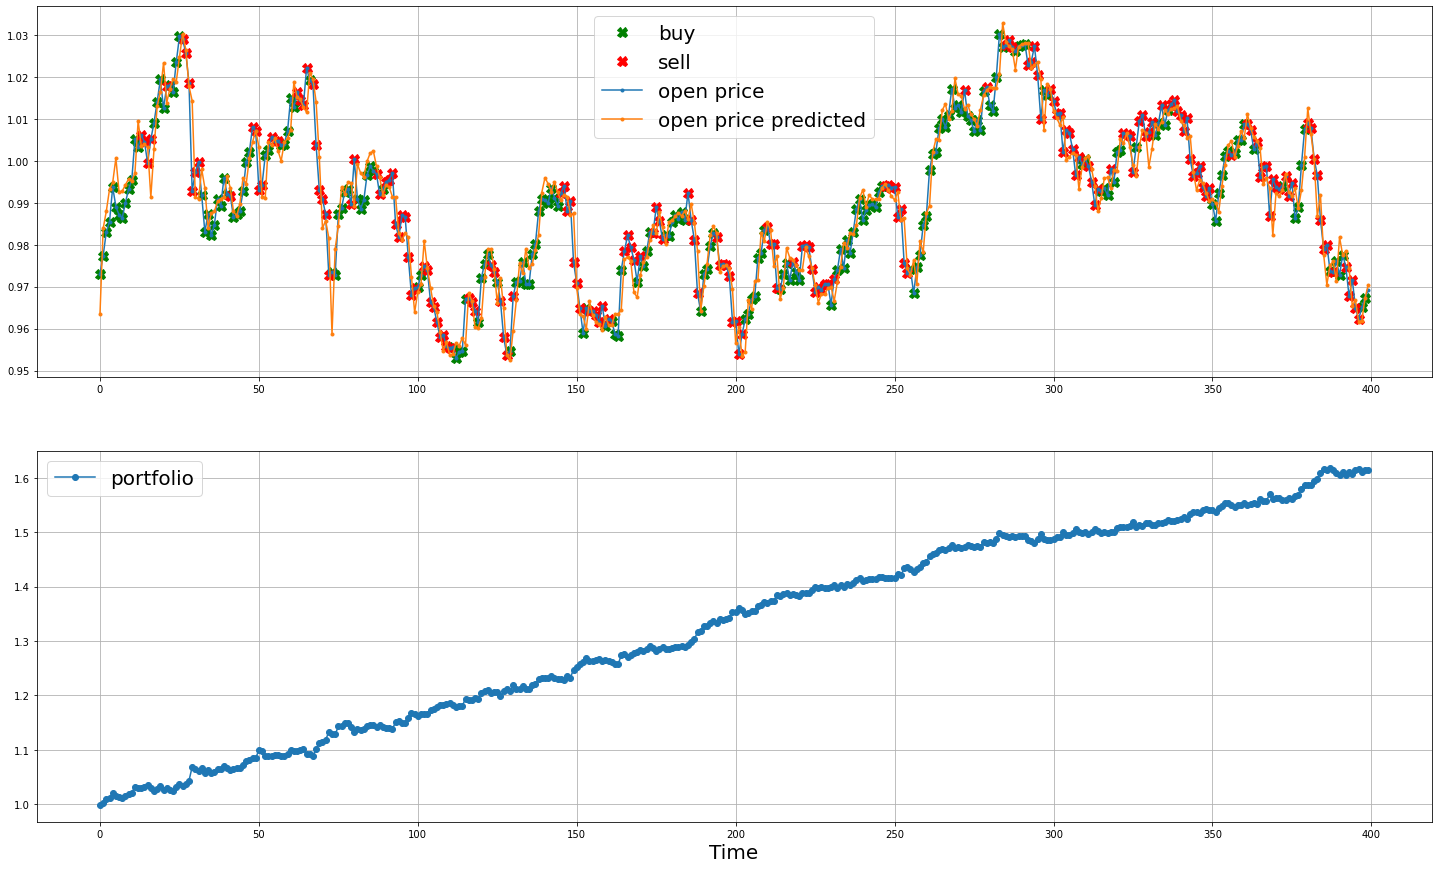

MSE           0.000131
ACC           0.668091
MEAN RET %    0.121087
Name: LSTM_AE_REG, dtype: float64

In [569]:
outputs_LSTM_AE_REG, targets, MSE = pl.evaluate(model_LSTM_AE_REG, test_x_smooth, test_y_reg[:,0].reshape(-1,1), device=device) 

tuple_min_max= norm[2]
outputs_LSTM_AE_REG = pp.min_max_norm_inverse(outputs_LSTM_AE_REG.reshape(-1,), tuple_min_max_=tuple_min_max) 
t = pp.min_max_norm_inverse(targets.reshape(-1,), tuple_min_max_=tuple_min_max)

MSE_LSTM_AE_REG = np.mean((outputs_LSTM_AE_REG-t)**2)
ACC_LSTM_AE_REG = pl.direction_accuracy(outputs_LSTM_AE_REG, t)
MEAN_RET_LSTM_AE_REG = pl.evauate_strategy(t, outputs_LSTM_AE_REG,plot=True)

result_price_df['LSTM_AE_REG'] = [MSE_LSTM_AE_REG, ACC_LSTM_AE_REG, MEAN_RET_LSTM_AE_REG]
result_price_df['LSTM_AE_REG']

##### GRU + AE + REG

In [538]:
model_GRU_AE_REG = ml.GRU_base(
        hidden_size=32,
        num_layers=2,
        input_size= train_x.shape[2],
        out_features_lin=32,
        out_features_end=1,
        dropout=0.1,
        device=device)
model_GRU_AE_REG.to(device)
model_GRU_AE_REG

GRU_base(
  (gru): GRU(34, 32, num_layers=2, batch_first=True, dropout=0.1)
  (fc0_bn): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_0): Linear(in_features=32, out_features=32, bias=True)
  (fc1_bn): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_1): Linear(in_features=32, out_features=1, bias=True)
  (relu): LeakyReLU(negative_slope=0.01)
)

 20%|██        | 201/1000 [00:27<01:46,  7.52it/s]

Epoch: 200/1000
MSE = [train loss mean :  0.37869662] , [val loss mean:  0.33688090, MSE (last) 2438.13705%]


 40%|████      | 401/1000 [00:54<01:30,  6.64it/s]

Epoch: 400/1000
MSE = [train loss mean :  0.21817198] , [val loss mean:  0.17538478, MSE (last) 2316.09459%]


 47%|████▋     | 472/1000 [01:04<01:11,  7.37it/s]


0.1703974782719332 < 0.1705252737157485
Epoch: 473/1000
MSE = [train loss mean :  0.21233257] , [val loss mean:  0.17249562, MSE (last) 2352.94304%]


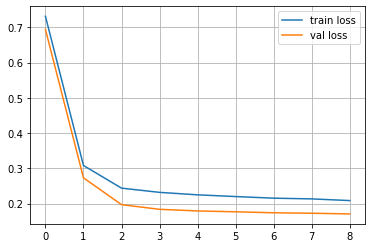

In [539]:
lr= 0.0001
num_epochs= 1000

train_loss, val_loss = pl.train_regularized(
    model=model_GRU_AE_REG,
    train_x_ = train_x_smooth,
    train_y_ =  train_y_reg[:,0].reshape(-1,1),
    val_x_ = val_x_smooth,
    val_y_=  val_y_reg[:,0].reshape(-1, 1),
    batch_size_=512,
    num_epochs_=num_epochs,
    lr_=lr,
    lambda_=0.01,
    device_=device,
    verbose = 1)
    
chunksize= int(num_epochs/20)
plt.plot(pl.smooth_loss(train_loss, chunksize = chunksize)[0:] , label="train loss")
plt.plot(pl.smooth_loss(val_loss, chunksize = chunksize)[0:] , label="val loss")
plt.legend()
plt.grid()
plt.show() 

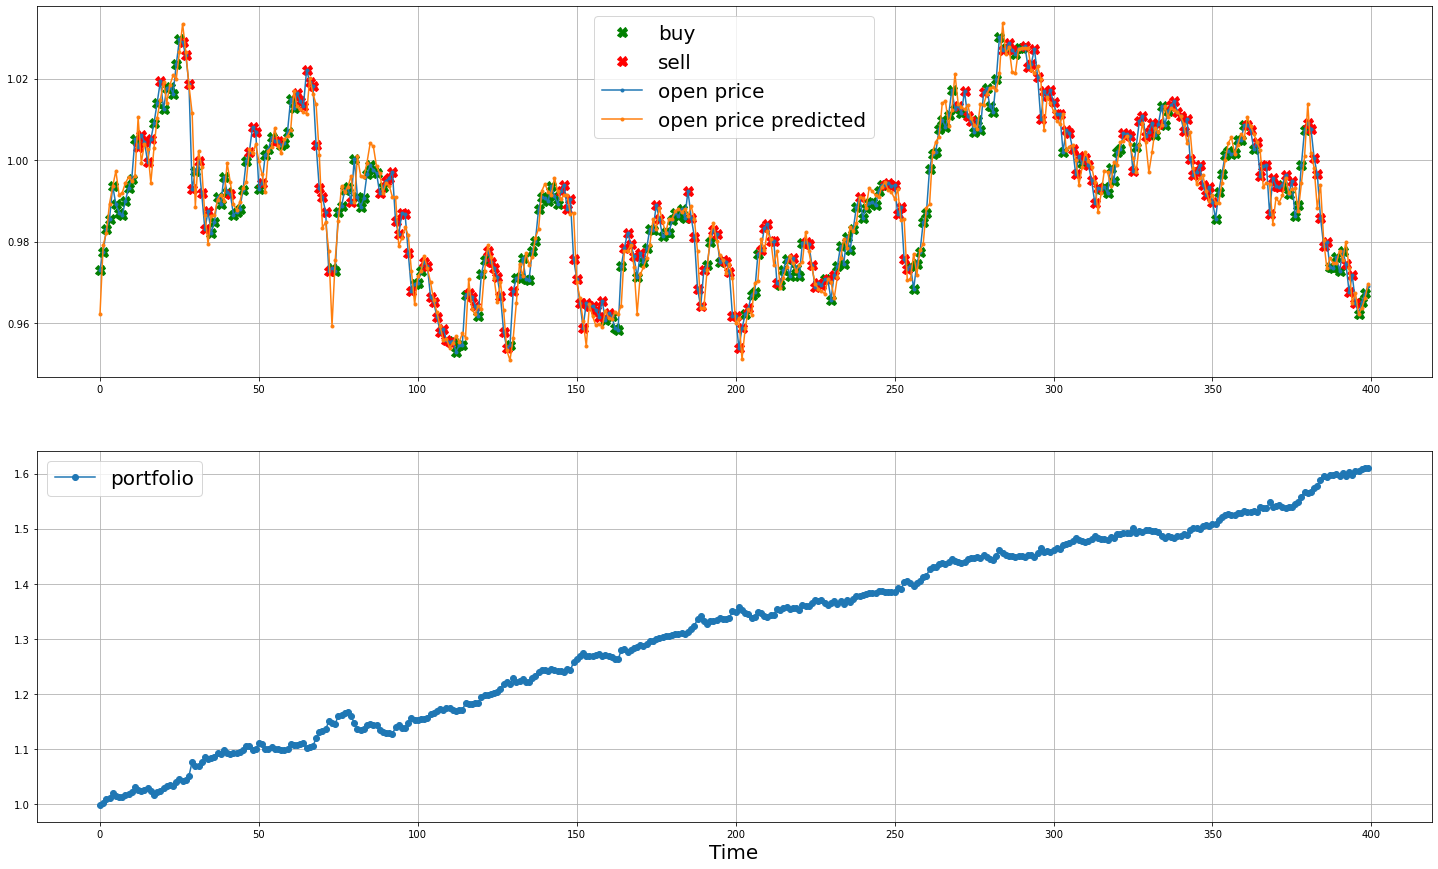

MSE           0.000139
ACC           0.678063
MEAN RET %    0.120573
Name: GRU_AE_REG, dtype: float64

In [570]:
outputs_GRU_AE_REG, targets, MSE = pl.evaluate(model_GRU_AE_REG, test_x_smooth, test_y_reg[:,0].reshape(-1,1), device=device) 

tuple_min_max= norm[2]
outputs_GRU_AE_REG = pp.min_max_norm_inverse(outputs_GRU_AE_REG.reshape(-1,), tuple_min_max_=tuple_min_max) 
t = pp.min_max_norm_inverse(targets.reshape(-1,), tuple_min_max_=tuple_min_max)

MSE_GRU_AE_REG = np.mean((outputs_GRU_AE_REG-t)**2)
ACC_GRU_AE_REG = pl.direction_accuracy(outputs_GRU_AE_REG, t)
MEAN_RET_GRU_AE_REG = pl.evauate_strategy(t, outputs_GRU_AE_REG, plot=True)

result_price_df['GRU_AE_REG'] = [MSE_GRU_AE_REG, ACC_GRU_AE_REG, MEAN_RET_GRU_AE_REG]
result_price_df['GRU_AE_REG']

### Trend prediction

#### Baseline

##### Dense 

In [587]:
model_Dense_Trend = ml.Dense(
    num_layers = 6,
    layer_size = 256,
    input_size = train_x.reshape(train_x.shape[0],-1).shape[1],
    output_size = 1,
    dropout=0.2)
model_Dense_Trend.to(device)
model_Dense_Trend

Dense(
  (net): Sequential(
    (0): Linear(in_features=204, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.2, inplace=False)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Dropout(p=0.2, inplace=False)
    (7): ReLU()
    (8): Linear(in_features=256, out_features=256, bias=True)
    (9): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Dropout(p=0.2, inplace=False)
    (11): ReLU()
    (12): Linear(in_features=256, out_features=256, bias=True)
    (13): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): Dropout(p=0.2, inplace=False)
    (15): ReLU()
    (16): Linear(in_features=256, out_features=256, bias=True)
    (17): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_runn

 20%|██        | 201/1000 [00:39<02:47,  4.76it/s]

Epoch: 200/1000
MSE = [train loss mean :  0.77386438] , [val loss mean:  0.69506937, MSE (last) 60.24547%]


 40%|████      | 401/1000 [01:18<01:46,  5.61it/s]

Epoch: 400/1000
MSE = [train loss mean :  0.62980667] , [val loss mean:  0.54446134, MSE (last) 49.97327%]


 60%|██████    | 601/1000 [01:56<01:18,  5.09it/s]

Epoch: 600/1000
MSE = [train loss mean :  0.52289900] , [val loss mean:  0.47312878, MSE (last) 45.31209%]


 76%|███████▌  | 761/1000 [02:29<00:46,  5.09it/s]


0.4428743666410446 < 0.44287558436393737
Epoch: 762/1000
MSE = [train loss mean :  0.45135096] , [val loss mean:  0.44858894, MSE (last) 44.40668%]


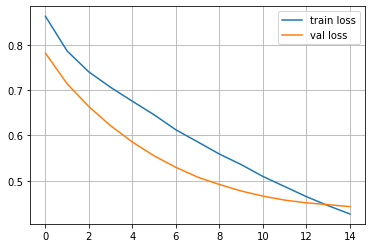

In [588]:
lr= 0.00001
num_epochs= 1000

train_loss, val_loss = pl.train(
    model=model_Dense_Trend,
    train_x_ = train_x.reshape(train_x.shape[0],-1),
    train_y_ =  train_y[:,0].reshape(-1,1),
    val_x_ = val_x.reshape(val_x.shape[0],-1),
    val_y_=  val_y[:,0].reshape(-1, 1),
    batch_size_=512,
    num_epochs_=num_epochs,
    lr_=lr,
    criterion_ = nn.BCEWithLogitsLoss(pos_weight=positive_weight),
    device_=device,
    verbose = 1)
    
chunksize= int(num_epochs/20)
plt.plot(pl.smooth_loss(train_loss, chunksize = chunksize)[0:] , label="train loss")
plt.plot(pl.smooth_loss(val_loss, chunksize = chunksize)[0:] , label="val loss")
plt.legend()
plt.grid()
plt.show() 

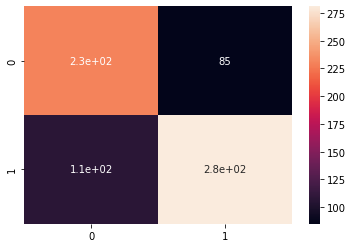

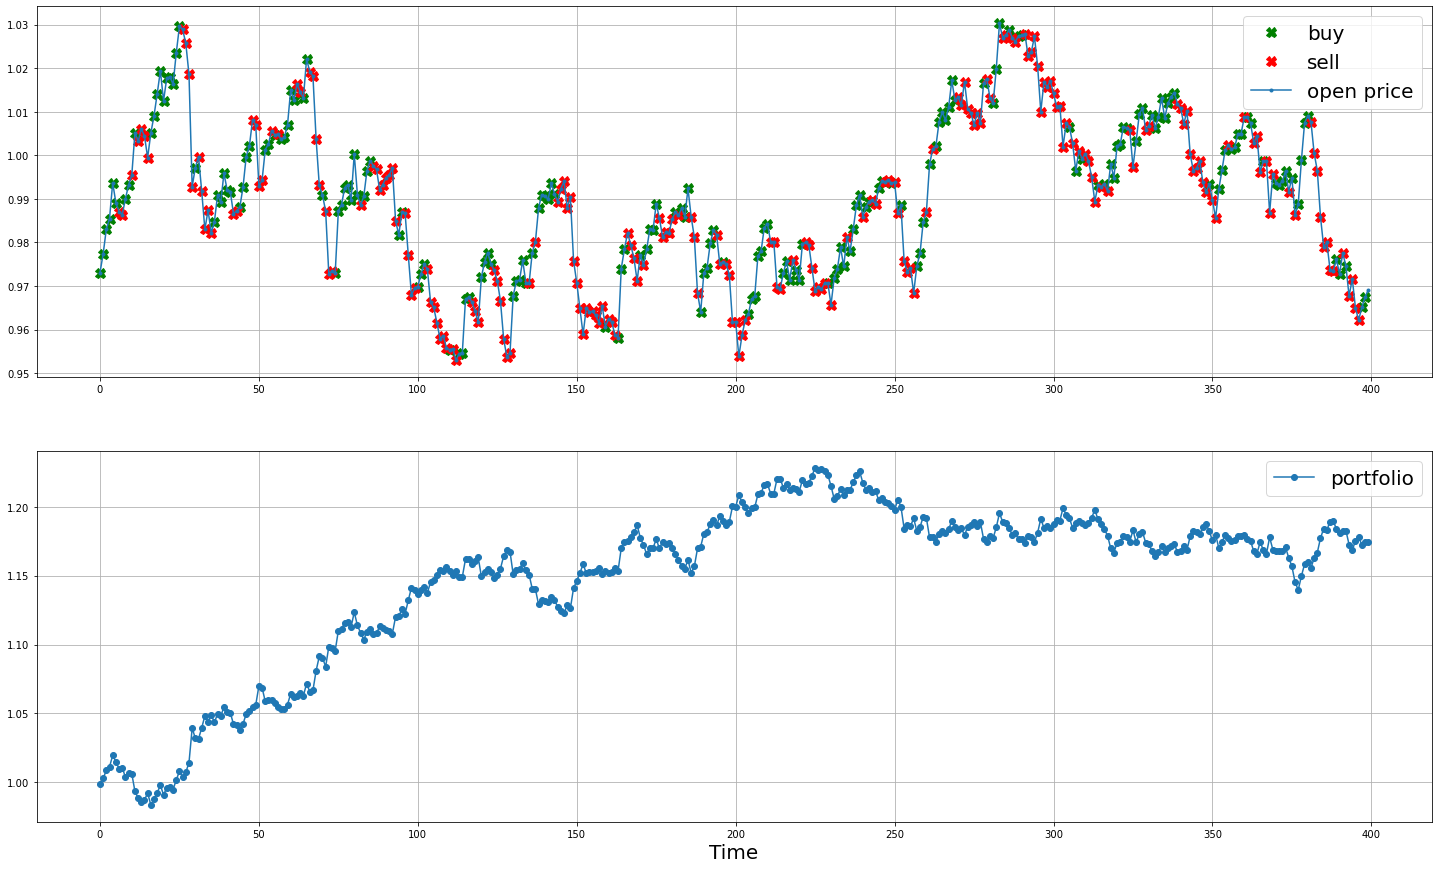

ACC           0.726885
MEAN RET %    0.041956
Name: Dense, dtype: float64

In [590]:
outputs_Dense_Trend, targets, ACC_Dense_Trend = pl.evaluate_trend(model_Dense_Trend, test_x.reshape(test_x.shape[0],-1), test_y[:,0].reshape(-1,1), device=device) 

sns.heatmap(data=confusion_matrix(targets, outputs_Dense_Trend), annot=True)
plt.plot()

tuple_min_max= norm[2]
t = pp.min_max_norm_inverse(test_y_reg[:,0], tuple_min_max_=tuple_min_max)

MEAN_RET_Dense_Trend = pl.evauate_strategy_trend(t, outputs_Dense_Trend,plot=True)

result_trend_df['Dense'] = [ACC_Dense_Trend, MEAN_RET_Dense_Trend]
result_trend_df['Dense']

##### LSTM

In [591]:
model_LSTM_Trend = ml.LSTM_base(
        hidden_size=16,
        num_layers=2,
        input_size= train_x.shape[2],
        out_features_lin=16,
        out_features_end=1,
        dropout=0.05,
        device=device)
model_LSTM_Trend.to(device)
model_LSTM_Trend

LSTM_base(
  (lstm): LSTM(34, 16, num_layers=2, batch_first=True, dropout=0.05)
  (fc0_bn): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_0): Linear(in_features=16, out_features=16, bias=True)
  (fc1_bn): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_1): Linear(in_features=16, out_features=1, bias=True)
  (relu): LeakyReLU(negative_slope=0.01)
)

 20%|██        | 202/1000 [00:19<01:15, 10.60it/s]

Epoch: 200/1000
MSE = [train loss mean :  0.60482183] , [val loss mean:  0.62414511, MSE (last) 52.76682%]


 35%|███▌      | 351/1000 [00:33<01:02, 10.33it/s]


0.4871508502960205 < 0.48720283269882203
Epoch: 352/1000
MSE = [train loss mean :  0.47362399] , [val loss mean:  0.50876340, MSE (last) 48.98461%]


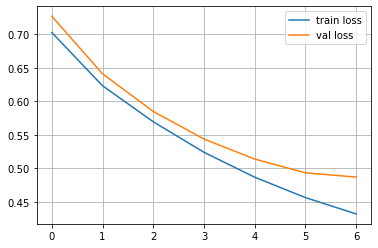

In [592]:
lr= 0.0001
num_epochs= 1000

train_loss, val_loss = pl.train(
    model=model_LSTM_Trend,
    train_x_ = train_x,
    train_y_ =  train_y[:,0].reshape(-1,1),
    val_x_ = val_x,
    val_y_=  val_y[:,0].reshape(-1, 1),
    batch_size_=512,
    num_epochs_=num_epochs,
    criterion_ = nn.BCEWithLogitsLoss(pos_weight=positive_weight),
    lr_=lr,
    device_=device,
    verbose = 1)
    
chunksize= int(num_epochs/20)
plt.plot(pl.smooth_loss(train_loss, chunksize = chunksize)[0:] , label="train loss")
plt.plot(pl.smooth_loss(val_loss, chunksize = chunksize)[0:] , label="val loss")
plt.legend()
plt.grid()
plt.show() 

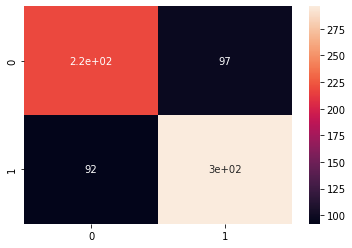

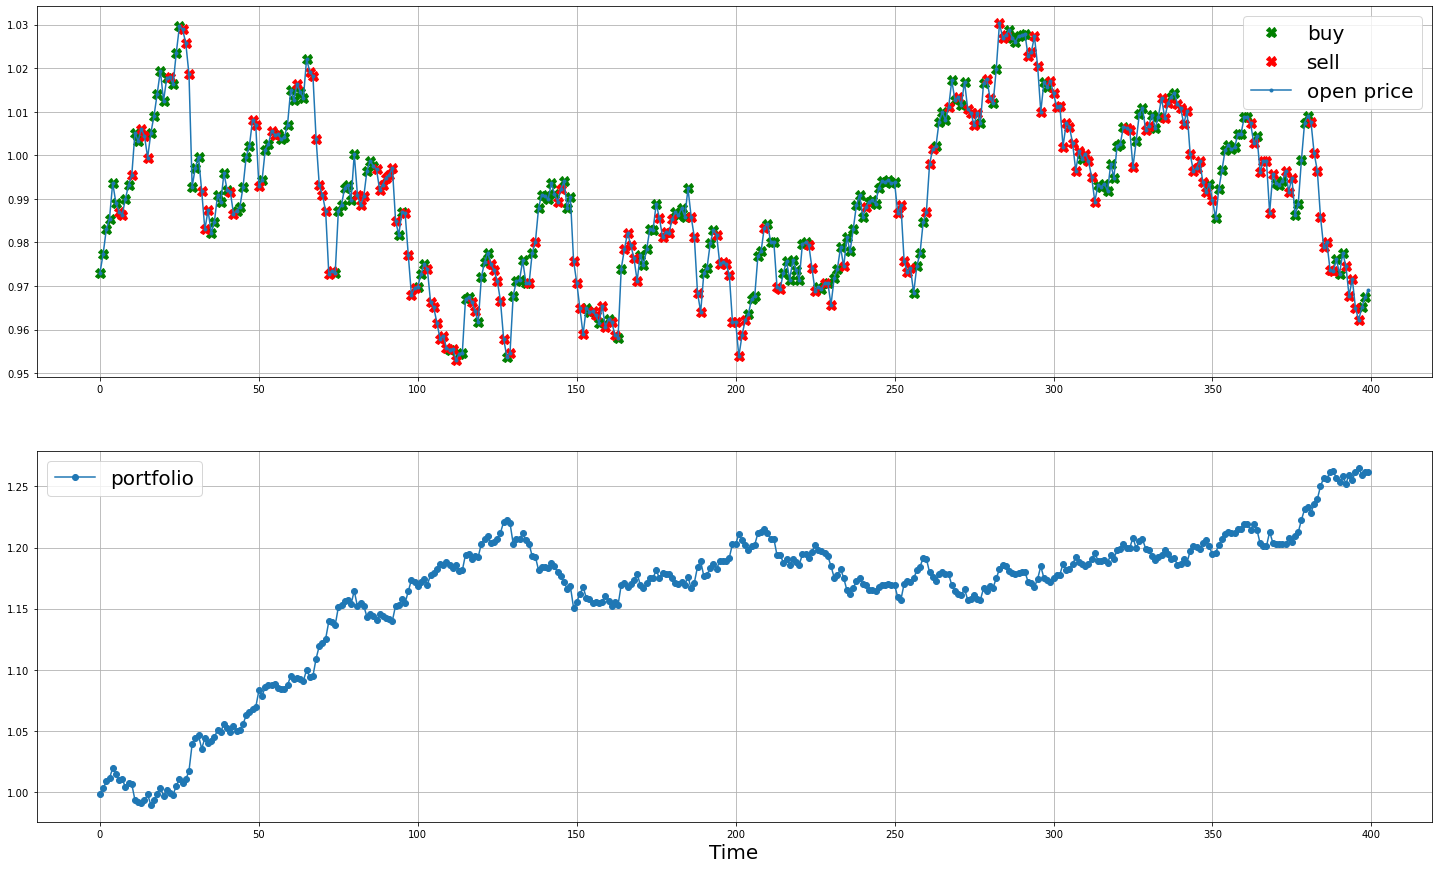

ACC           0.731152
MEAN RET %    0.059756
Name: LSTM, dtype: float64

In [599]:
outputs_LSTM_Trend, targets, ACC_LSTM_Trend = pl.evaluate_trend(model_LSTM_Trend, test_x, test_y[:,0].reshape(-1,1), device=device) 

sns.heatmap(data=confusion_matrix(targets, outputs_LSTM_Trend), annot=True)
plt.plot()

tuple_min_max= norm[2]
t = pp.min_max_norm_inverse(test_y_reg[:,0].reshape(-1,), tuple_min_max_=tuple_min_max)

MEAN_RET_LSTM_Trend = pl.evauate_strategy_trend(t, outputs_LSTM_Trend,plot=True)

result_trend_df['LSTM'] = [ACC_LSTM_Trend, MEAN_RET_LSTM_Trend]
result_trend_df['LSTM']

##### GRU

In [596]:
model_GRU_Trend = ml.GRU_base(
        hidden_size=32,
        num_layers=2,
        input_size= train_x.shape[2],
        out_features_lin=32,
        out_features_end=1,
        dropout=0.05,
        device=device)
model_GRU_Trend.to(device)
model_GRU_Trend

GRU_base(
  (gru): GRU(34, 32, num_layers=2, batch_first=True, dropout=0.05)
  (fc0_bn): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_0): Linear(in_features=32, out_features=32, bias=True)
  (fc1_bn): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_1): Linear(in_features=32, out_features=1, bias=True)
  (relu): LeakyReLU(negative_slope=0.01)
)

 20%|██        | 201/1000 [00:30<01:45,  7.56it/s]

Epoch: 200/1000
MSE = [train loss mean :  0.53722115] , [val loss mean:  0.52168323, MSE (last) 42.17910%]


 24%|██▍       | 239/1000 [00:35<01:51,  6.81it/s]


0.4219243168830872 < 0.4219648218154907
Epoch: 240/1000
MSE = [train loss mean :  0.47052149] , [val loss mean:  0.47006001, MSE (last) 42.28407%]


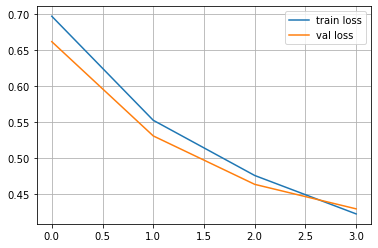

In [597]:
lr= 0.0001
num_epochs= 1000

train_loss, val_loss = pl.train(
    model=model_GRU_Trend,
    train_x_ = train_x,
    train_y_ =  train_y[:,0].reshape(-1,1),
    val_x_ = val_x,
    val_y_=  val_y[:,0].reshape(-1, 1),
    batch_size_=512,
    num_epochs_=num_epochs,
    criterion_ = nn.BCEWithLogitsLoss(pos_weight=positive_weight),
    lr_=lr,
    device_=device,
    verbose = 1)
    
chunksize= int(num_epochs/20)
plt.plot(pl.smooth_loss(train_loss, chunksize = chunksize)[0:] , label="train loss")
plt.plot(pl.smooth_loss(val_loss, chunksize = chunksize)[0:] , label="val loss")
plt.legend()
plt.grid()
plt.show() 

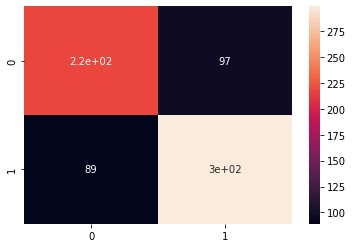

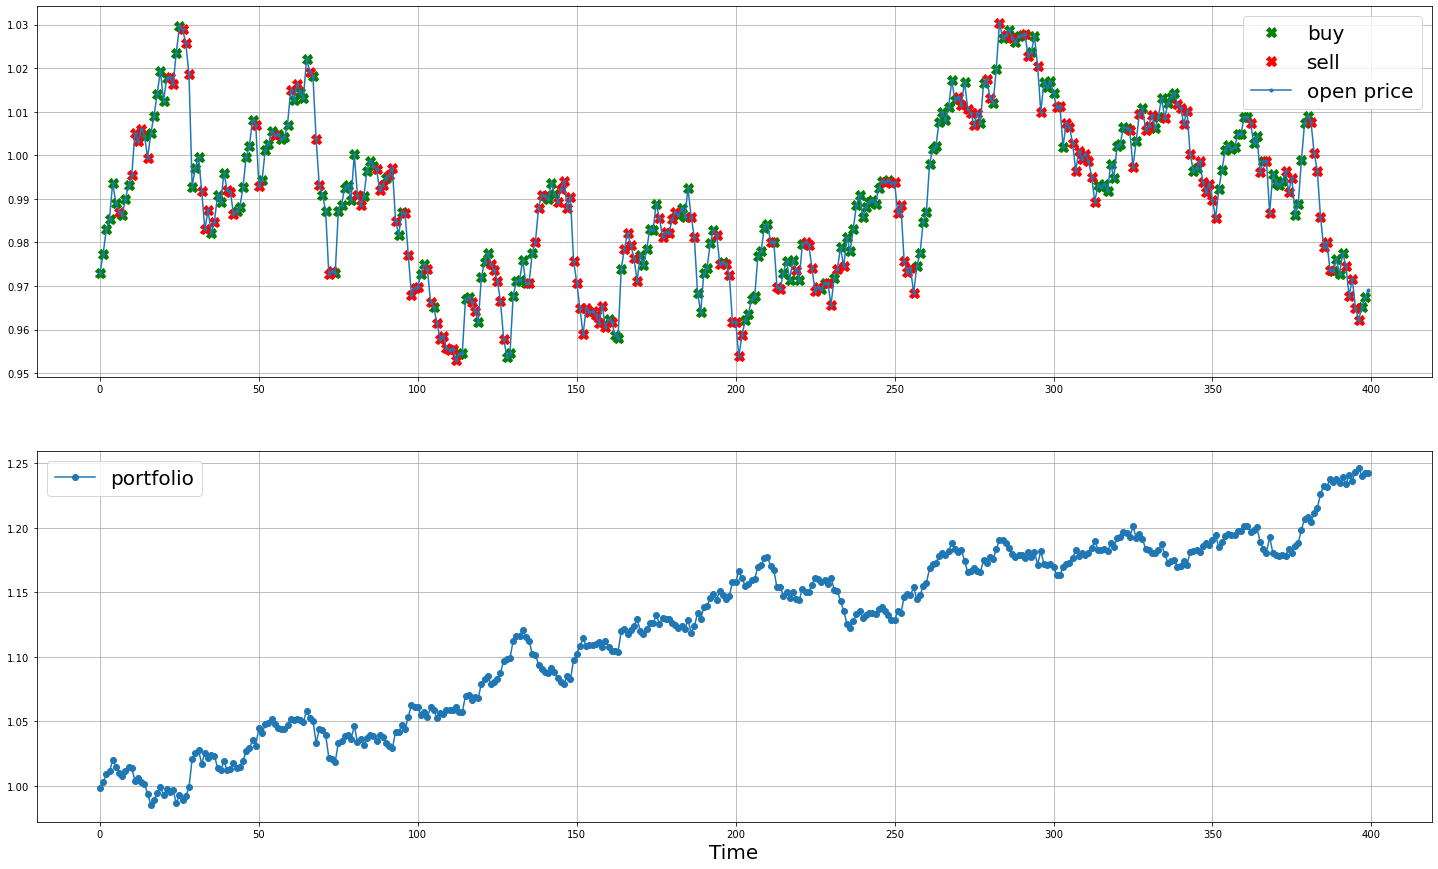

ACC           0.735420
MEAN RET %    0.056104
Name: GRU, dtype: float64

In [601]:
outputs_GRU_Trend, targets, ACC_GRU_Trend = pl.evaluate_trend(model_GRU_Trend, test_x, test_y[:,0].reshape(-1,1), device=device) 

sns.heatmap(data=confusion_matrix(targets, outputs_GRU_Trend), annot=True)
plt.plot()

tuple_min_max= norm[2]
t = pp.min_max_norm_inverse(test_y_reg[:,0].reshape(-1,), tuple_min_max_=tuple_min_max)

MEAN_RET_GRU_Trend = pl.evauate_strategy_trend(t, outputs_GRU_Trend, plot=True)

result_trend_df['GRU'] = [ACC_GRU_Trend, MEAN_RET_GRU_Trend]
result_trend_df['GRU']

#### Add Auto-Encoder 

##### Dense + AE

In [606]:
model_Dense_AE_Trend = ml.Dense(
    num_layers = 6,
    layer_size = 256,
    input_size = train_x.reshape(train_x.shape[0],-1).shape[1],
    output_size = 1,
    dropout=0.2)
model_Dense_AE_Trend.to(device)
model_Dense_AE_Trend

Dense(
  (net): Sequential(
    (0): Linear(in_features=204, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.2, inplace=False)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Dropout(p=0.2, inplace=False)
    (7): ReLU()
    (8): Linear(in_features=256, out_features=256, bias=True)
    (9): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Dropout(p=0.2, inplace=False)
    (11): ReLU()
    (12): Linear(in_features=256, out_features=256, bias=True)
    (13): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): Dropout(p=0.2, inplace=False)
    (15): ReLU()
    (16): Linear(in_features=256, out_features=256, bias=True)
    (17): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_runn

 20%|██        | 201/1000 [00:38<02:41,  4.95it/s]

Epoch: 200/1000
MSE = [train loss mean :  0.75267343] , [val loss mean:  0.68548414, MSE (last) 64.76055%]


 40%|████      | 401/1000 [01:14<02:13,  4.48it/s]

Epoch: 400/1000
MSE = [train loss mean :  0.68981031] , [val loss mean:  0.63835399, MSE (last) 63.10720%]


 47%|████▋     | 471/1000 [01:27<01:38,  5.37it/s]


0.6280439114570617 < 0.628076114654541
Epoch: 472/1000
MSE = [train loss mean :  0.67980942] , [val loss mean:  0.63296263, MSE (last) 62.78409%]


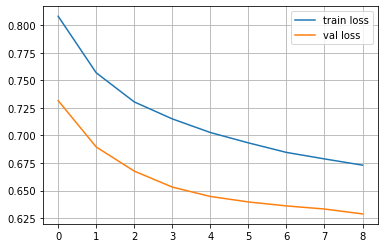

In [607]:
lr= 0.00001
num_epochs= 1000

train_loss, val_loss = pl.train(
    model=model_Dense_AE_Trend,
    train_x_ = train_x_smooth.reshape(train_x.shape[0],-1),
    train_y_ =  train_y[:,0].reshape(-1,1),
    val_x_ = val_x_smooth.reshape(val_x.shape[0],-1),
    val_y_=  val_y[:,0].reshape(-1, 1),
    batch_size_=512,
    num_epochs_=num_epochs,
    lr_=lr,
    criterion_ = nn.BCEWithLogitsLoss(pos_weight=positive_weight),
    device_=device,
    verbose = 1)
    
chunksize= int(num_epochs/20)
plt.plot(pl.smooth_loss(train_loss, chunksize = chunksize)[0:] , label="train loss")
plt.plot(pl.smooth_loss(val_loss, chunksize = chunksize)[0:] , label="val loss")
plt.legend()
plt.grid()
plt.show() 

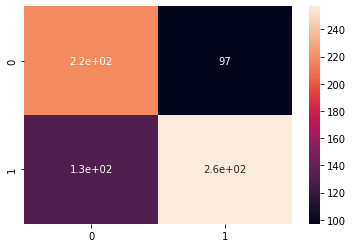

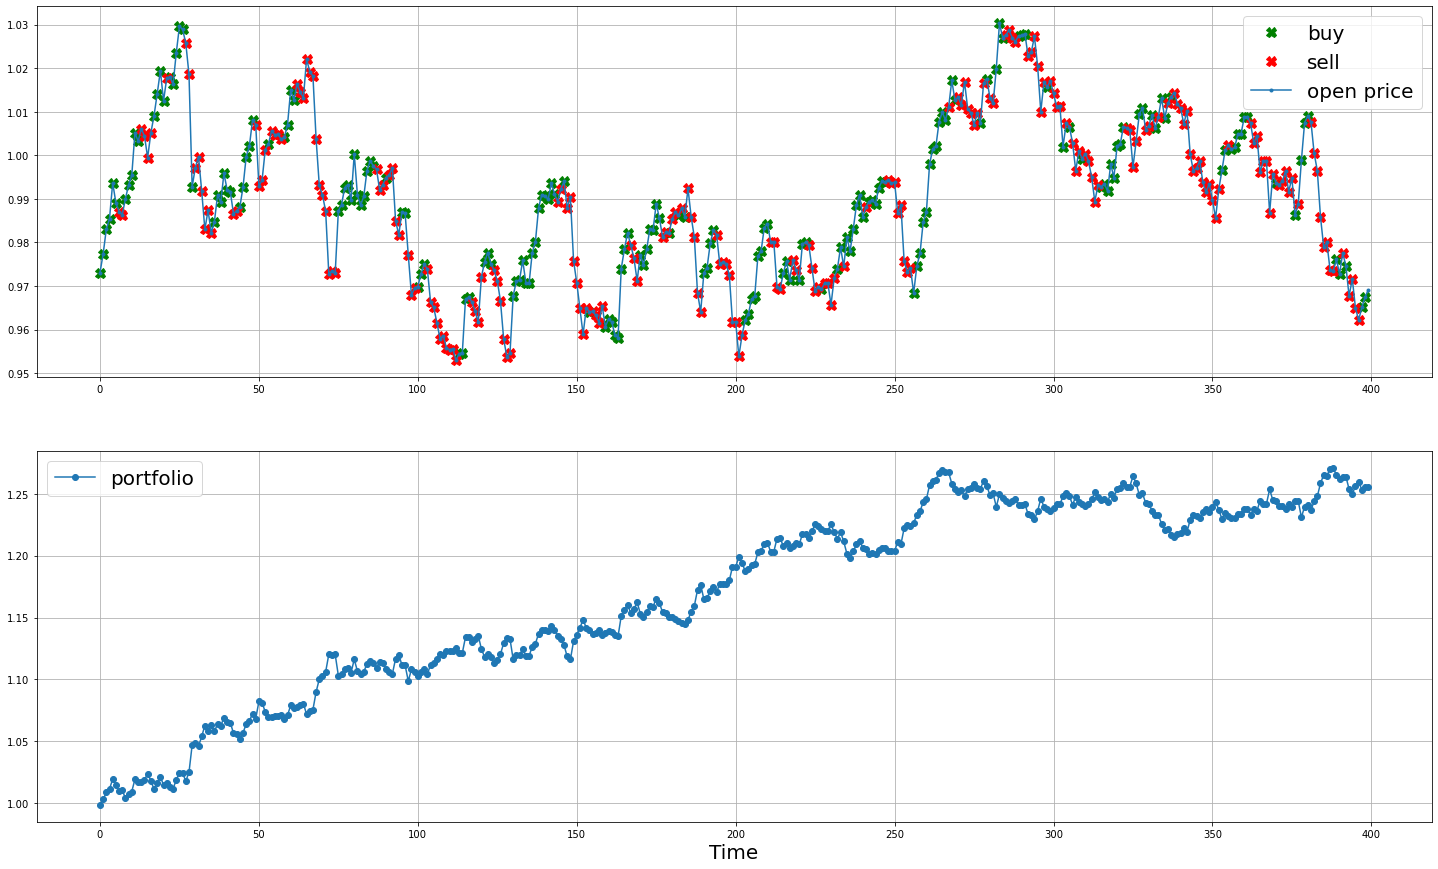

ACC           0.675676
MEAN RET %    0.058575
Name: Dense_AE, dtype: float64

In [608]:
outputs_Dense_AE_Trend, targets, ACC_Dense_AE_Trend = pl.evaluate_trend(model_Dense_AE_Trend, test_x_smooth.reshape(test_x.shape[0],-1), test_y[:,0].reshape(-1,1), device=device) 

sns.heatmap(data=confusion_matrix(targets, outputs_Dense_AE_Trend), annot=True)
plt.plot()

tuple_min_max= norm[2]
t = pp.min_max_norm_inverse(test_y_reg[:,0], tuple_min_max_=tuple_min_max)

MEAN_RET_Dense_AE_Trend = pl.evauate_strategy_trend(t, outputs_Dense_AE_Trend,plot=True)

result_trend_df['Dense_AE'] = [ACC_Dense_AE_Trend, MEAN_RET_Dense_AE_Trend]
result_trend_df['Dense_AE']

##### LSTM + AE

In [611]:
model_LSTM_AE_Trend = ml.LSTM_base(
        hidden_size=16,
        num_layers=2,
        input_size= train_x.shape[2],
        out_features_lin=16,
        out_features_end=1,
        dropout=0.05,
        device=device)
model_LSTM_AE_Trend.to(device)
model_LSTM_AE_Trend

LSTM_base(
  (lstm): LSTM(34, 16, num_layers=2, batch_first=True, dropout=0.05)
  (fc0_bn): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_0): Linear(in_features=16, out_features=16, bias=True)
  (fc1_bn): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_1): Linear(in_features=16, out_features=1, bias=True)
  (relu): LeakyReLU(negative_slope=0.01)
)

 20%|██        | 201/1000 [00:18<01:17, 10.27it/s]

Epoch: 200/1000
MSE = [train loss mean :  0.70071567] , [val loss mean:  0.70964592, MSE (last) 63.66465%]


 30%|███       | 302/1000 [00:28<01:06, 10.45it/s]


0.6186067795753479 < 0.6186370754241943
Epoch: 303/1000
MSE = [train loss mean :  0.62924158] , [val loss mean:  0.63911182, MSE (last) 61.82311%]


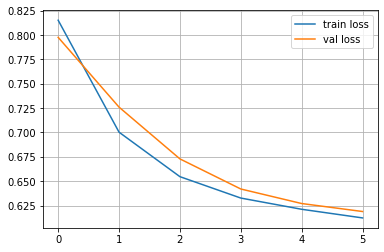

In [612]:
lr= 0.0001
num_epochs= 1000

train_loss, val_loss = pl.train(
    model=model_LSTM_AE_Trend,
    train_x_ = train_x_smooth,
    train_y_ =  train_y[:,0].reshape(-1,1),
    val_x_ = val_x_smooth,
    val_y_=  val_y[:,0].reshape(-1, 1),
    batch_size_=512,
    num_epochs_=num_epochs,
    criterion_ = nn.BCEWithLogitsLoss(pos_weight=positive_weight),
    lr_=lr,
    device_=device,
    verbose = 1)
    
chunksize= int(num_epochs/20)
plt.plot(pl.smooth_loss(train_loss, chunksize = chunksize)[0:] , label="train loss")
plt.plot(pl.smooth_loss(val_loss, chunksize = chunksize)[0:] , label="val loss")
plt.legend()
plt.grid()
plt.show() 

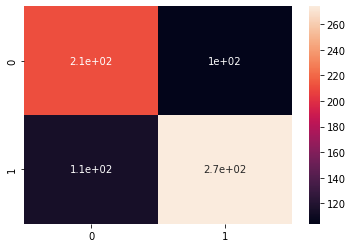

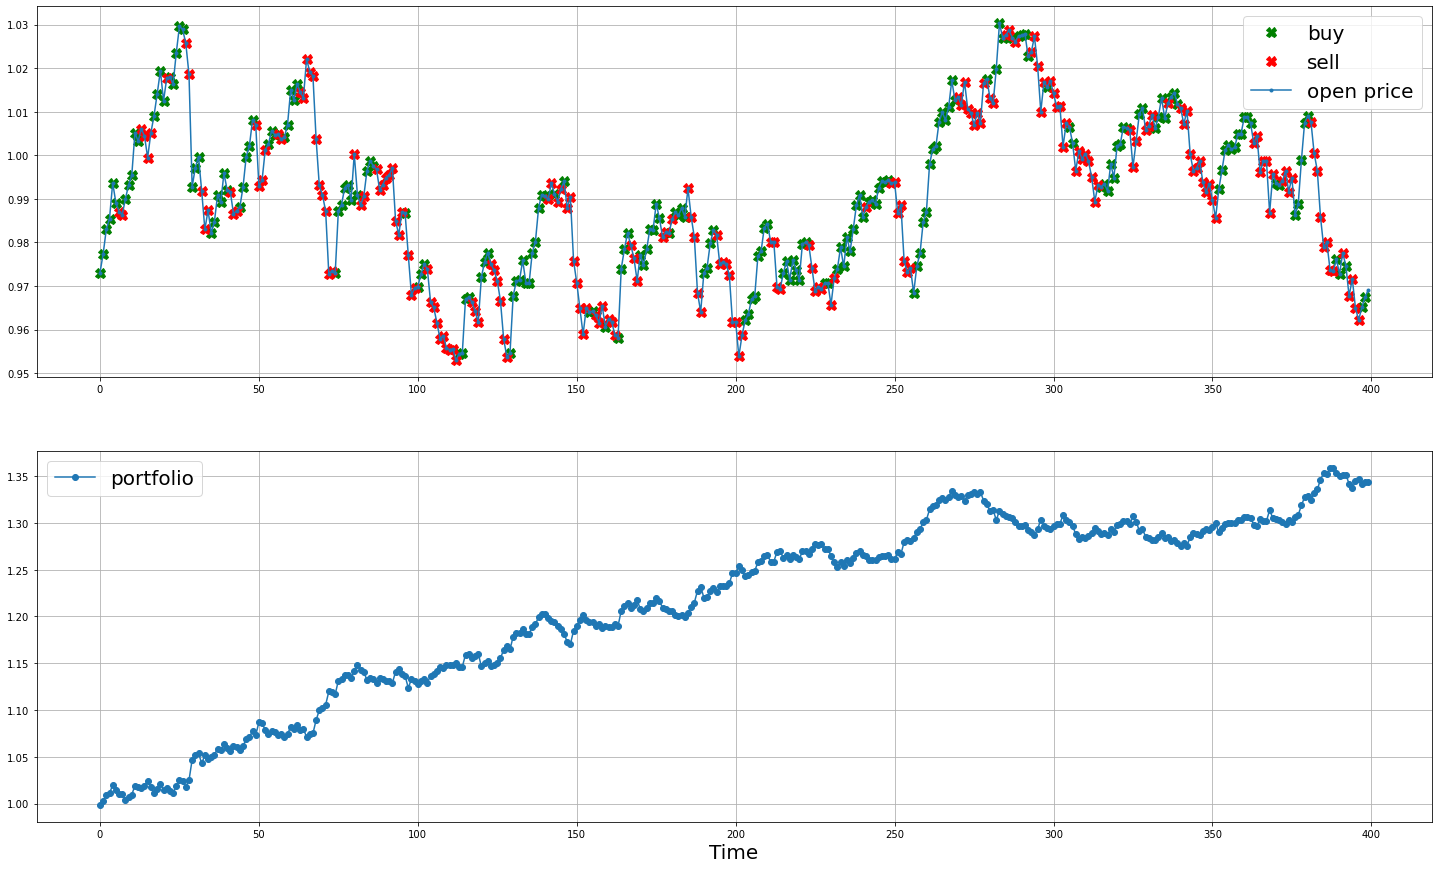

ACC           0.689900
MEAN RET %    0.075459
Name: LSTM_AE, dtype: float64

In [613]:
outputs_LSTM_AE_Trend, targets, ACC_LSTM_AE_Trend = pl.evaluate_trend(model_LSTM_AE_Trend, test_x_smooth, test_y[:,0].reshape(-1,1), device=device) 

sns.heatmap(data=confusion_matrix(targets, outputs_LSTM_AE_Trend), annot=True)
plt.plot()

tuple_min_max= norm[2]
t = pp.min_max_norm_inverse(test_y_reg[:,0].reshape(-1,), tuple_min_max_=tuple_min_max)

MEAN_RET_LSTM_AE_Trend = pl.evauate_strategy_trend(t, outputs_LSTM_AE_Trend,plot=True)

result_trend_df['LSTM_AE'] = [ACC_LSTM_AE_Trend, MEAN_RET_LSTM_AE_Trend]
result_trend_df['LSTM_AE']

##### GRU + AE

In [615]:
model_GRU_AE_Trend = ml.GRU_base(
        hidden_size=32,
        num_layers=2,
        input_size= train_x.shape[2],
        out_features_lin=32,
        out_features_end=1,
        dropout=0.05,
        device=device)
model_GRU_AE_Trend.to(device)
model_GRU_AE_Trend

GRU_base(
  (gru): GRU(34, 32, num_layers=2, batch_first=True, dropout=0.05)
  (fc0_bn): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_0): Linear(in_features=32, out_features=32, bias=True)
  (fc1_bn): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_1): Linear(in_features=32, out_features=1, bias=True)
  (relu): LeakyReLU(negative_slope=0.01)
)

 20%|██        | 201/1000 [00:27<01:37,  8.16it/s]

Epoch: 200/1000
MSE = [train loss mean :  0.64773431] , [val loss mean:  0.68097817, MSE (last) 65.84265%]


 24%|██▍       | 245/1000 [00:33<01:42,  7.39it/s]


0.6568842780590057 < 0.6569035029411316
Epoch: 246/1000
MSE = [train loss mean :  0.61715922] , [val loss mean:  0.66674508, MSE (last) 65.62871%]


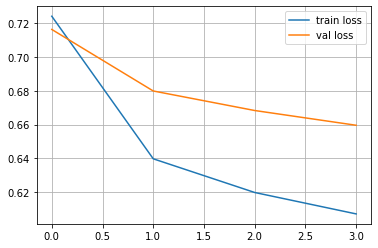

In [616]:
lr= 0.0001
num_epochs= 1000

train_loss, val_loss = pl.train(
    model=model_GRU_AE_Trend,
    train_x_ = train_x_smooth,
    train_y_ =  train_y[:,0].reshape(-1,1),
    val_x_ = val_x_smooth,
    val_y_=  val_y[:,0].reshape(-1, 1),
    batch_size_=512,
    num_epochs_=num_epochs,
    criterion_ = nn.BCEWithLogitsLoss(pos_weight=positive_weight),
    lr_=lr,
    device_=device,
    verbose = 1)
    
chunksize= int(num_epochs/20)
plt.plot(pl.smooth_loss(train_loss, chunksize = chunksize)[0:] , label="train loss")
plt.plot(pl.smooth_loss(val_loss, chunksize = chunksize)[0:] , label="val loss")
plt.legend()
plt.grid()
plt.show() 

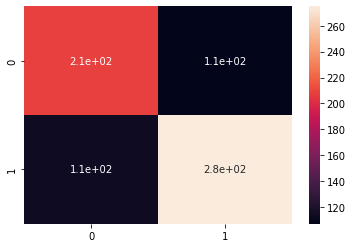

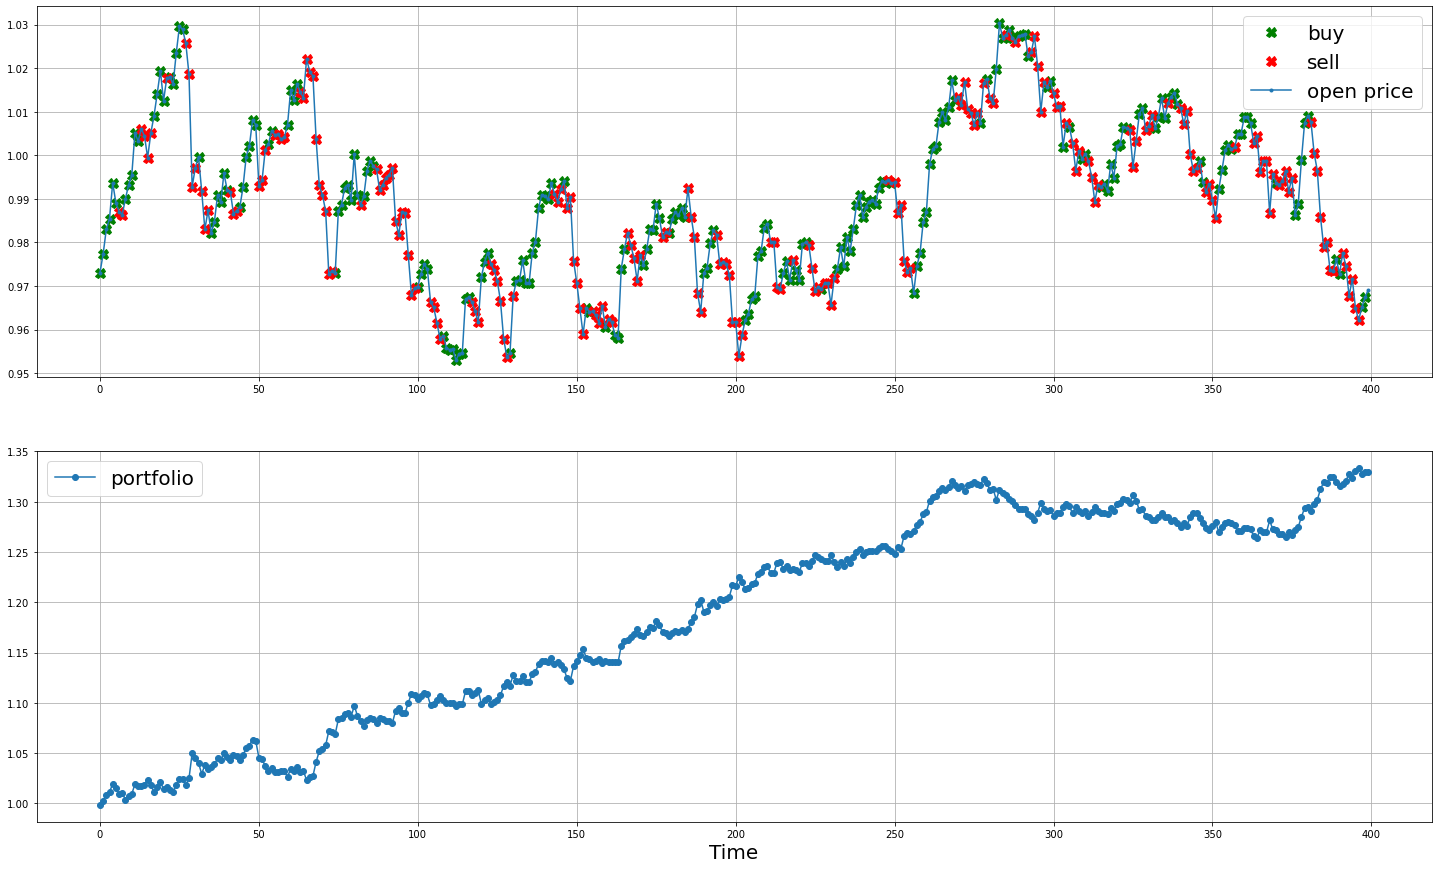

ACC           0.687055
MEAN RET %    0.072943
Name: GRU_AE, dtype: float64

In [617]:
outputs_GRU_AE_Trend, targets, ACC_GRU_AE_Trend = pl.evaluate_trend(model_GRU_AE_Trend, test_x_smooth, test_y[:,0].reshape(-1,1), device=device) 

sns.heatmap(data=confusion_matrix(targets, outputs_GRU_AE_Trend), annot=True)
plt.plot()

tuple_min_max= norm[2]
t = pp.min_max_norm_inverse(test_y_reg[:,0].reshape(-1,), tuple_min_max_=tuple_min_max)

MEAN_RET_GRU_AE_Trend = pl.evauate_strategy_trend(t, outputs_GRU_AE_Trend, plot=True)

result_trend_df['GRU_AE'] = [ACC_GRU_AE_Trend, MEAN_RET_GRU_AE_Trend]
result_trend_df['GRU_AE']

## Result 

### Price

In [571]:
result_price_df.head()

Dense      LSTM       GRU  Dense_AE   LSTM_AE    GRU_AE  \
MSE         0.000084  0.000079  0.000115  0.000129  0.000126  0.000127   
ACC         0.679487  0.685185  0.713675  0.678063  0.676638  0.682336   
MEAN RET %  0.098465  0.110107  0.111509  0.137447  0.124539  0.113620   

            Dense_AE_REG  LSTM_AE_REG  GRU_AE_REG  
MSE             0.000124     0.000131    0.000139  
ACC             0.678063     0.668091    0.678063  
MEAN RET %      0.120484     0.121087    0.120573

### Trend 

In [622]:
result_trend_df.head()

Dense      LSTM       GRU  Dense_AE   LSTM_AE    GRU_AE  \
ACC         0.726885  0.731152  0.735420  0.675676  0.689900  0.687055   
MEAN RET %  0.041956  0.059756  0.056104  0.058575  0.075459  0.072943   

            Dense_AE_REG  
ACC             0.514936  
MEAN RET %     -0.076966